In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_theme(context="poster", style="darkgrid", palette="colorblind")

## Load the experiment results

In [ ]:
!unzip Results.zip

Archive:  Results.zip
  inflating: Results/mergesort_0_2_0.log  
  inflating: Results/mergesort_0_2_1.log  
  inflating: Results/mergesort_0_2_10.log  
  inflating: Results/mergesort_0_2_11.log  
  inflating: Results/mergesort_0_2_12.log  
  inflating: Results/mergesort_0_2_13.log  
  inflating: Results/mergesort_0_2_14.log  
  inflating: Results/mergesort_0_2_15.log  
  inflating: Results/mergesort_0_2_16.log  
  inflating: Results/mergesort_0_2_17.log  
  inflating: Results/mergesort_0_2_18.log  
  inflating: Results/mergesort_0_2_19.log  
  inflating: Results/mergesort_0_2_2.log  
  inflating: Results/mergesort_0_2_20.log  
  inflating: Results/mergesort_0_2_21.log  
  inflating: Results/mergesort_0_2_22.log  
  inflating: Results/mergesort_0_2_23.log  
  inflating: Results/mergesort_0_2_24.log  
  inflating: Results/mergesort_0_2_25.log  
  inflating: Results/mergesort_0_2_26.log  
  inflating: Results/mergesort_0_2_27.log  
  inflating: Results/mergesort_0_2_28.log  
  inflating: 

In [ ]:
names = glob.glob("Results/mergesort_[0-9]*_[0-9]*_[0-9]*.log")
print("Log files:", len(names))

Log files: 369


In [ ]:
algo = ["Serial", "Parallel 1", "Parallel 2"]

In [ ]:
numbers = re.compile("[0-9]+")
info = [numbers.findall(i) for i in names]  # algorithm, cores, (log-)size
info = [i for i in info if len(i) == 3]  # only valid files
algorithms = [int(i[0]) for i in info]
cores = [int(i[1]) for i in info]
logsize = [int(i[2]) for i in info]

In [ ]:
df = pd.DataFrame({"name":names, "algorithms":algorithms, "cores":cores, "logsize":logsize})
df = df[df["logsize"] <= 28]
df

,name,algorithms,cores,logsize
0,Results/mergesort_1_16_9.log,1,16,9
1,Results/mergesort_0_2_8.log,0,2,8
2,Results/mergesort_0_1_22.log,0,1,22
3,Results/mergesort_1_32_4.log,1,32,4
4,Results/mergesort_0_1_10.log,0,1,10
...,...,...,...,...
364,Results/mergesort_2_32_7.log,2,32,7
365,Results/mergesort_2_16_20.log,2,16,20
366,Results/mergesort_1_4_13.log,1,4,13
367,Results/mergesort_2_8_3.log,2,8,3


In [ ]:
times = []
std = []
sizes = []
repetitions = []
seeds = []
for n in df["name"]:        
    tmp = pd.read_csv(n, delimiter=":", header=None, index_col =0).T
    times.append(float(tmp.get("Mean", "nan")))
    std.append(float(tmp.get("Std", "nan")))
    size, rep, _, seed = tmp.iloc[0, 0].strip()[1:-1].split(",")
    sizes.append(int(size))
    repetitions.append(int(rep))
    seeds.append(int(seed))

In [ ]:
df["time"] = times
df["std"] = std
df["size"] = sizes
df["repetition"] = repetitions
df["seed"] = seeds

df

,name,algorithms,cores,logsize,time,std,size,repetition,seed
0,Results/mergesort_1_16_9.log,1,16,9,0.005754,0.0,512,10,0
1,Results/mergesort_0_2_8.log,0,2,8,0.000018,0.0,256,10,0
2,Results/mergesort_0_1_22.log,0,1,22,0.385048,0.0,4194304,10,0
3,Results/mergesort_1_32_4.log,1,32,4,0.000007,0.0,16,10,0
4,Results/mergesort_0_1_10.log,0,1,10,0.000074,0.0,1024,10,0
...,...,...,...,...,...,...,...,...,...
364,Results/mergesort_2_32_7.log,2,32,7,0.000399,0.0,128,10,0
365,Results/mergesort_2_16_20.log,2,16,20,0.024791,0.0,1048576,10,0
366,Results/mergesort_1_4_13.log,1,4,13,0.000266,0.0,8192,10,0
367,Results/mergesort_2_8_3.log,2,8,3,0.000131,0.0,8,10,0


## Make tables

For each algo make a table with *size* x *cores*, then compute the table with speedup and efficiency. 

In [ ]:
def make_table(df, algo):
    tmp = df[df["algorithms"] == algo][["cores", "logsize", "time", "std"]].sort_values(by=["logsize"])
    tmp = tmp.set_index("logsize")
    table_time = pd.DataFrame(index = set(tmp.index))
    table_std = pd.DataFrame(index = set(tmp.index))
    cores = list(set(tmp["cores"]))
    cores.sort()
    for c in cores:
        table_time[c] = tmp[tmp["cores"] == c]["time"]
        table_std[c] = tmp[tmp["cores"] == c]["std"]
    return table_time, table_std

time_ser, std_ser = make_table(df, 0)
time_p1, std_p1 = make_table(df, 1)
time_p2, std_p2 = make_table(df, 2)

In [ ]:
speedup_p1 = (1 / time_p1).mul(time_ser[2], 0)
speedup_p2 = (1 / time_p2).mul(time_ser[2], 0)

efficiency_p1 = speedup_p1 / speedup_p1.columns
efficiency_p2 = speedup_p2 / speedup_p2.columns

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0})
MAX_CORES = 32

def plot_speedup(logsize):
    fig, ax = plt.subplots(figsize=(15, 10))    
    r = np.arange(2, MAX_CORES + 1, 0.5)
    ax.scatter(r, r, marker=".", label="Linear Speedup")
    ax.plot(speedup_p1.columns, speedup_p1.loc[logsize], label=f"Parallel Split", marker="o")
    ax.plot(speedup_p2.columns, speedup_p2.loc[logsize], label=f"Paraller Split and Merge", marker="x")

    ax.legend(fontsize=16)
    ax.set_title(f"Speedup - Size 2^{logsize}", fontsize=24)
    ax.set_xlabel("#Cores", fontsize=16)
    ax.set_ylabel("Speedup", fontsize=16)
    ax.grid(True)
    fig.show()

def plot_efficiency(logsize):
    fig, ax = plt.subplots(figsize=(15, 10))    
    r = np.arange(2, MAX_CORES + 1, 0.5)
    ax.scatter(r, [0.66 for i in r], marker=".", label="66% Efficieny")
    ax.plot(efficiency_p1.columns, efficiency_p1.loc[logsize], label=f"Parallel Split", marker="o")
    ax.plot(efficiency_p2.columns, efficiency_p2.loc[logsize], label=f"Paraller Split and Merge", marker="x")

    ax.legend(fontsize=16)
    ax.set_title(f"Efficiency - Size 2^{logsize}", fontsize=24)
    ax.set_xlabel("#Cores", fontsize=16)
    ax.set_ylabel("Efficiency", fontsize=16)
    ax.grid(True)
    fig.show()

def plot_time(core):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(time_ser, label=f"Serial", marker="o")
    ax.plot(time_p1[core], label=f"Parallel Split", marker="o")
    ax.plot(time_p2[core], label=f"Paraller Split and Merge", marker="x")

    ax.legend(fontsize=16)
    ax.set_title(f"Time - Cores: {core}", fontsize=24)
    ax.set_xlabel("Log Size", fontsize=16)
    ax.set_ylabel("Log Seconds", fontsize=16)
    ax.set_yscale('log')
    ax.grid(True)
    fig.show()

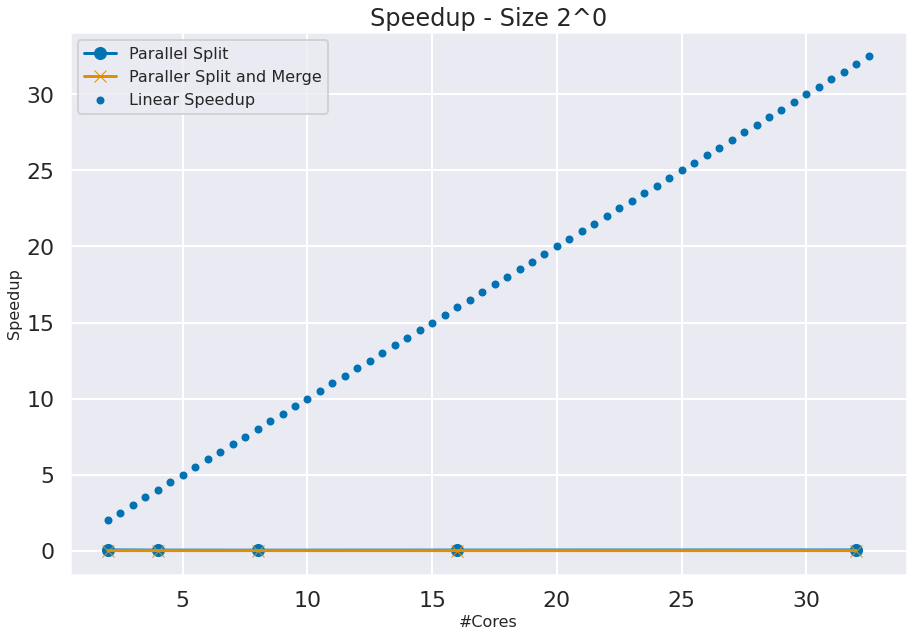

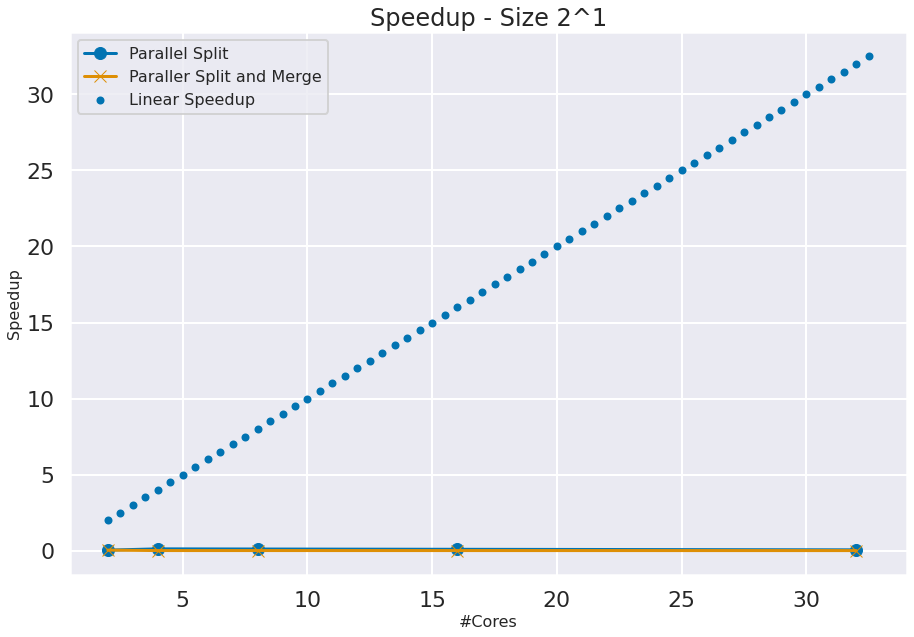

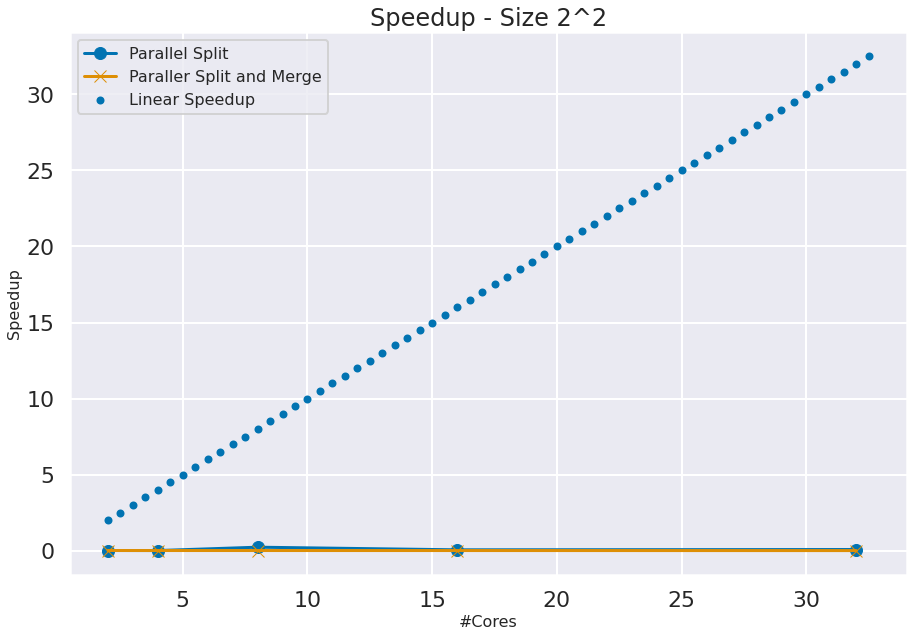

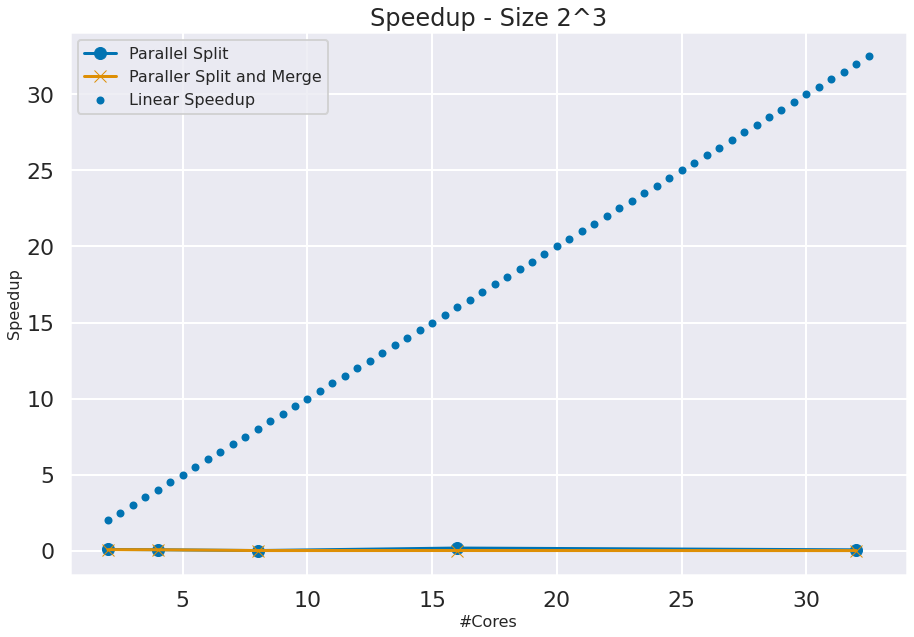

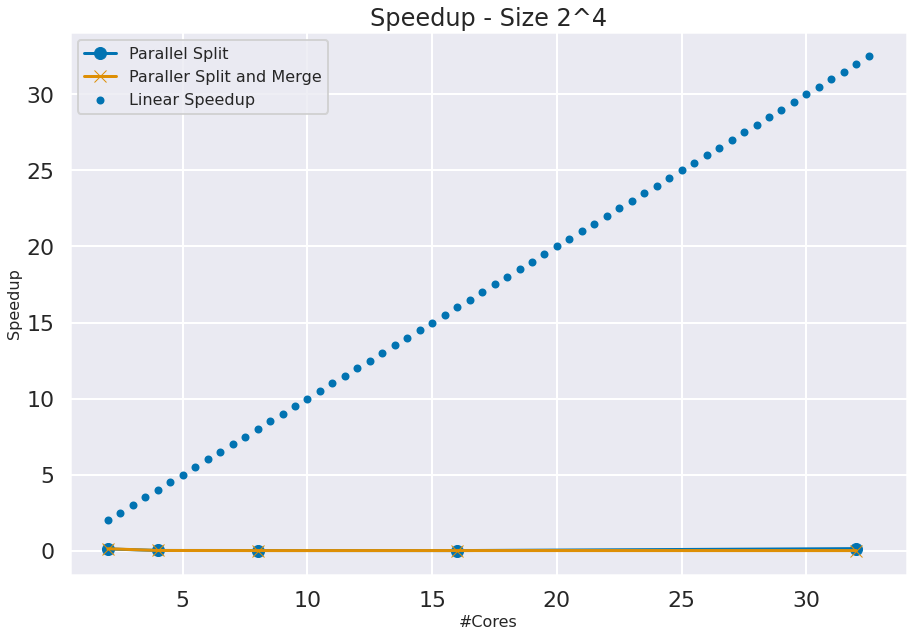

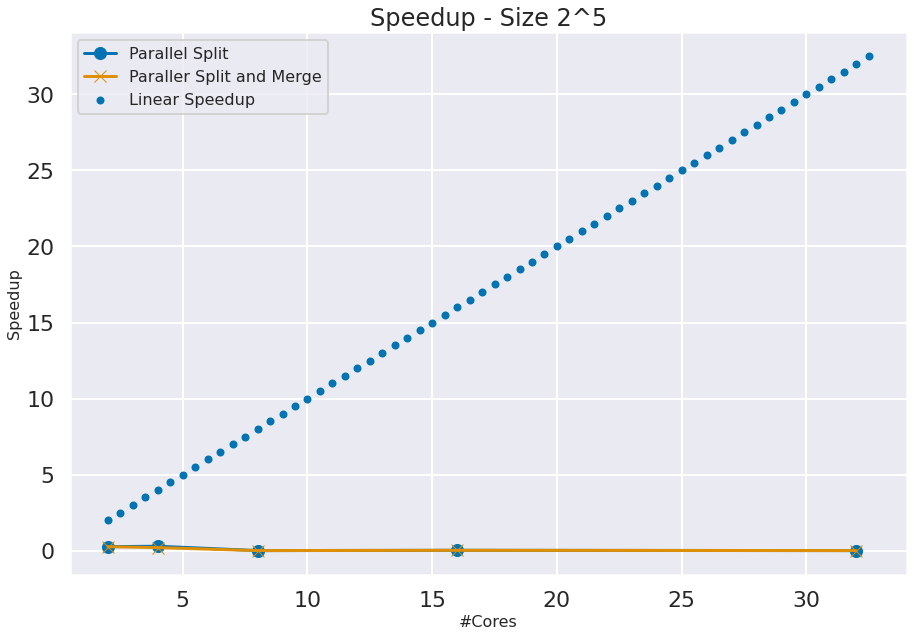

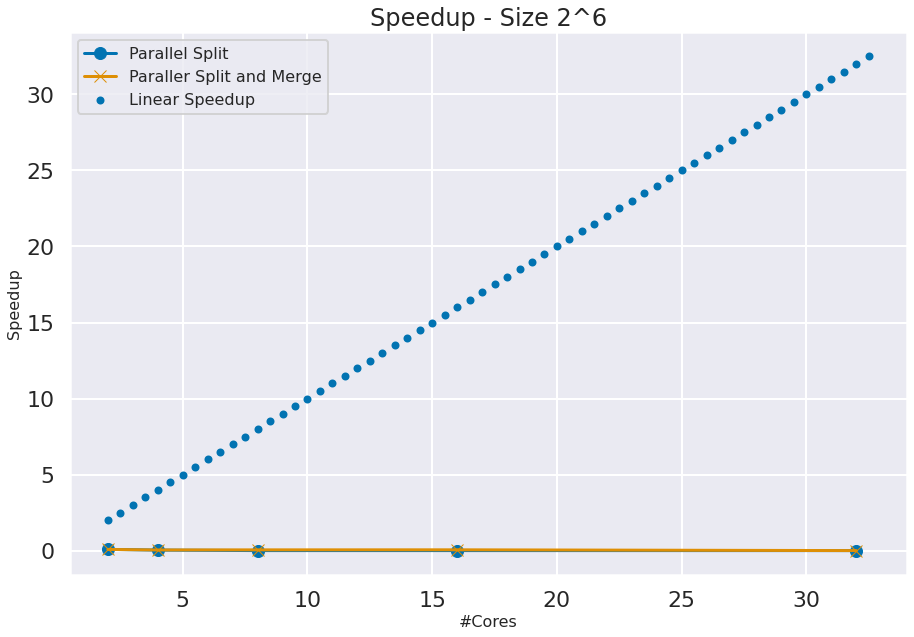

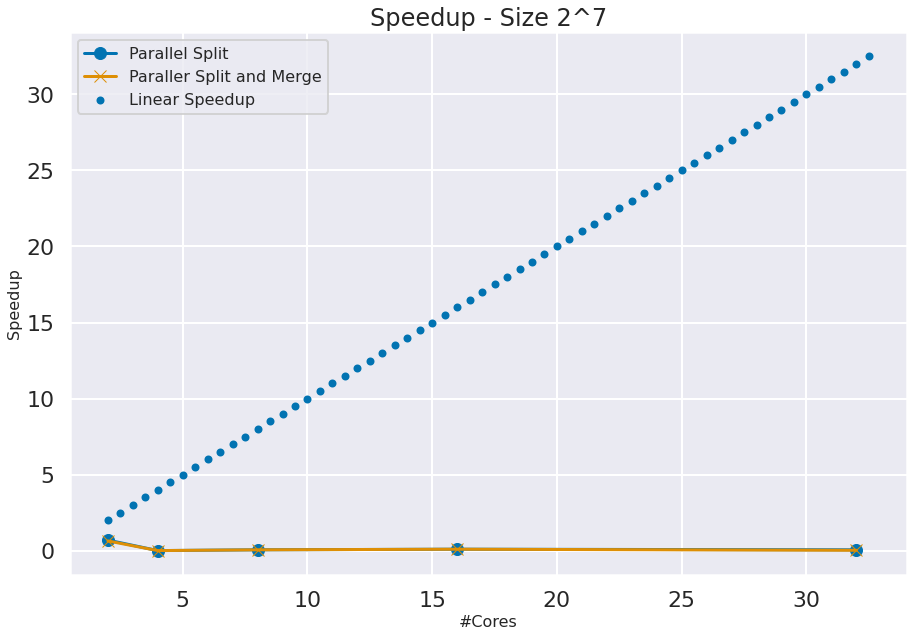

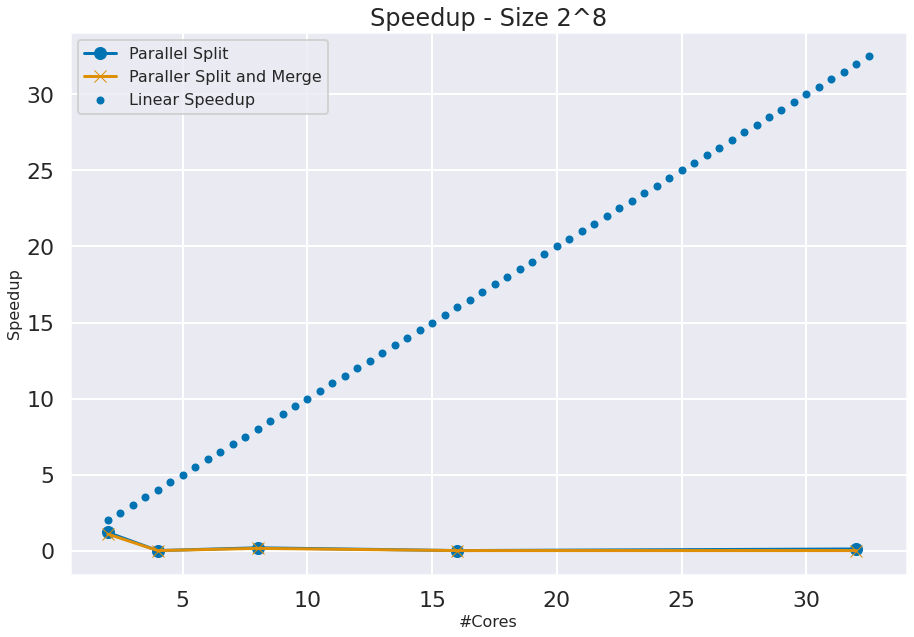

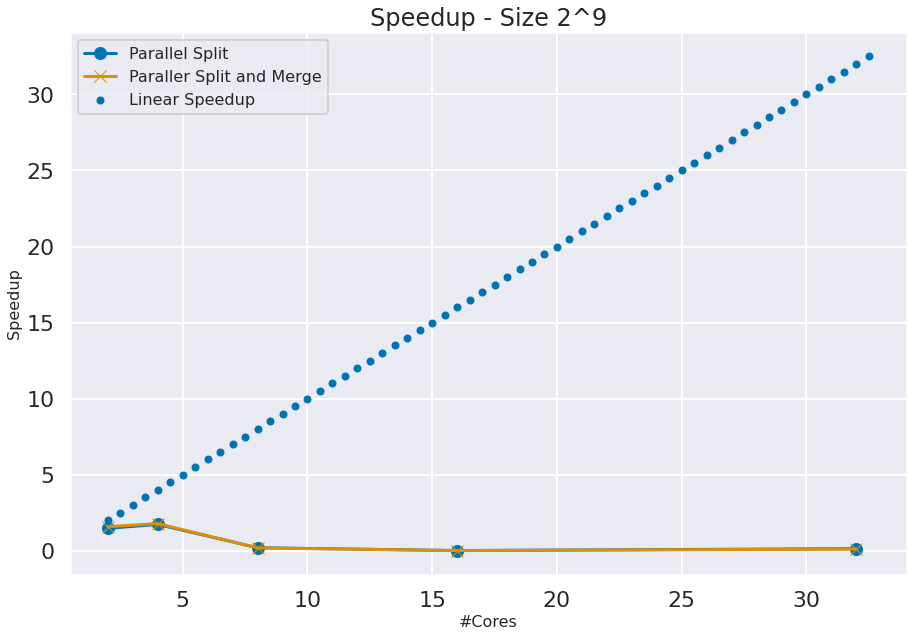

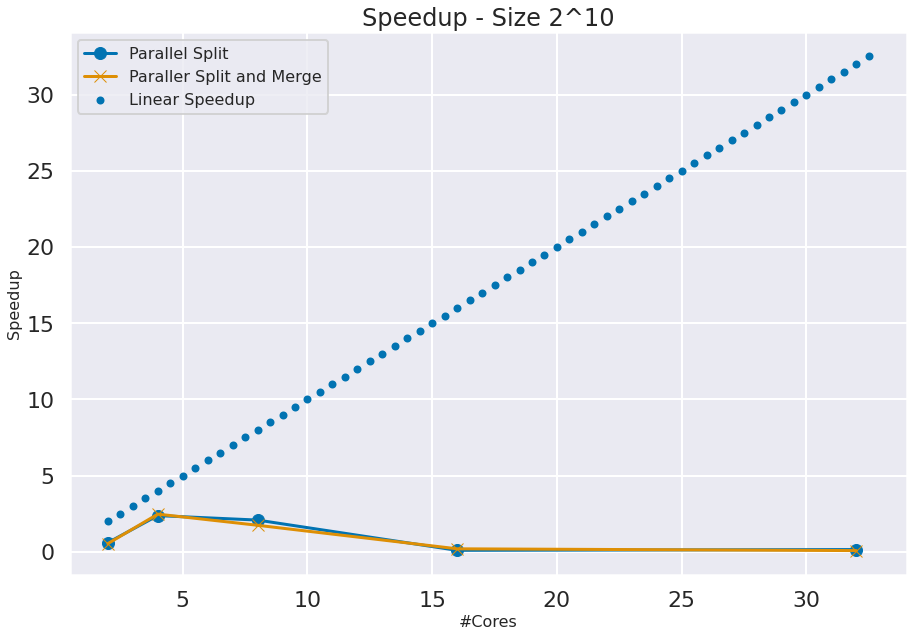

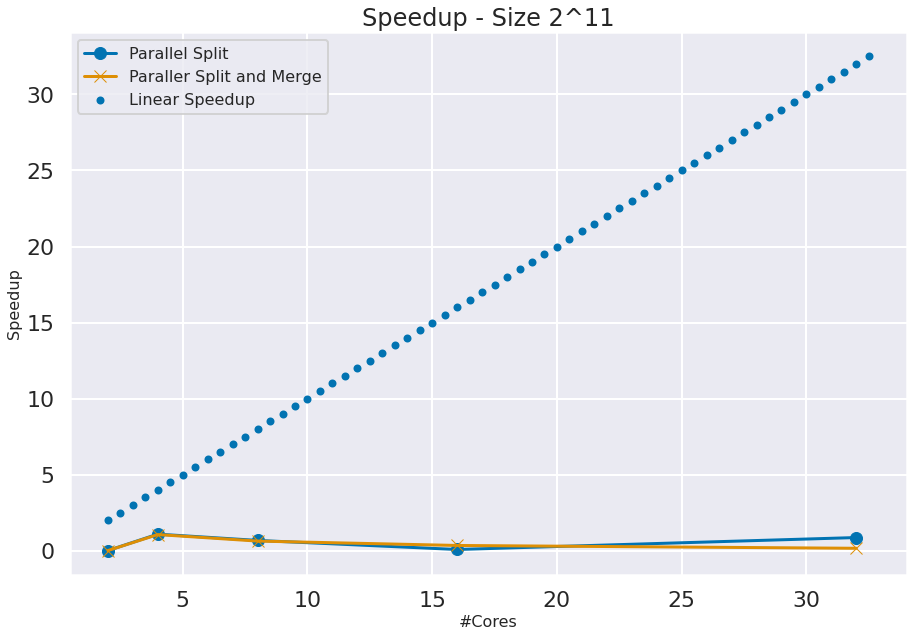

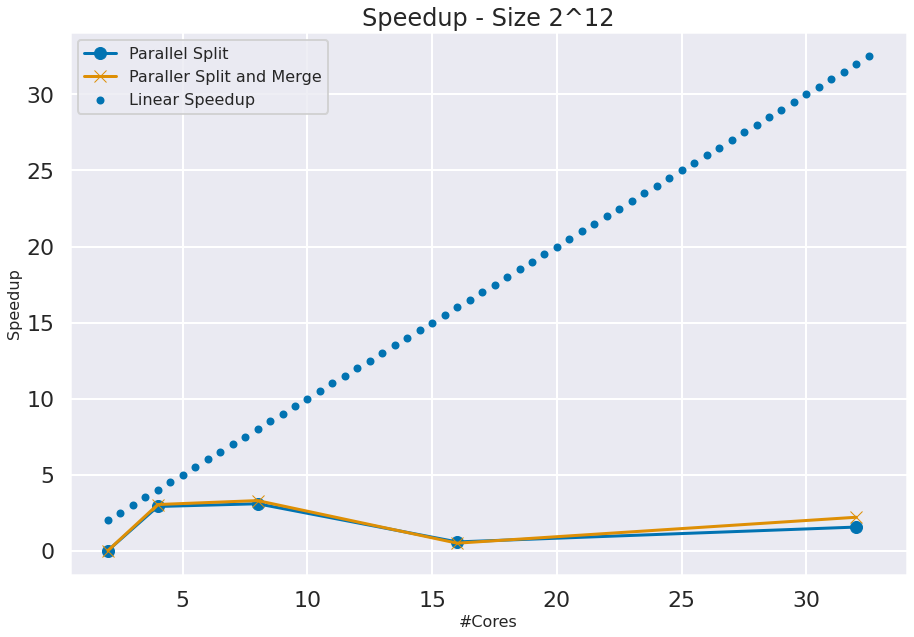

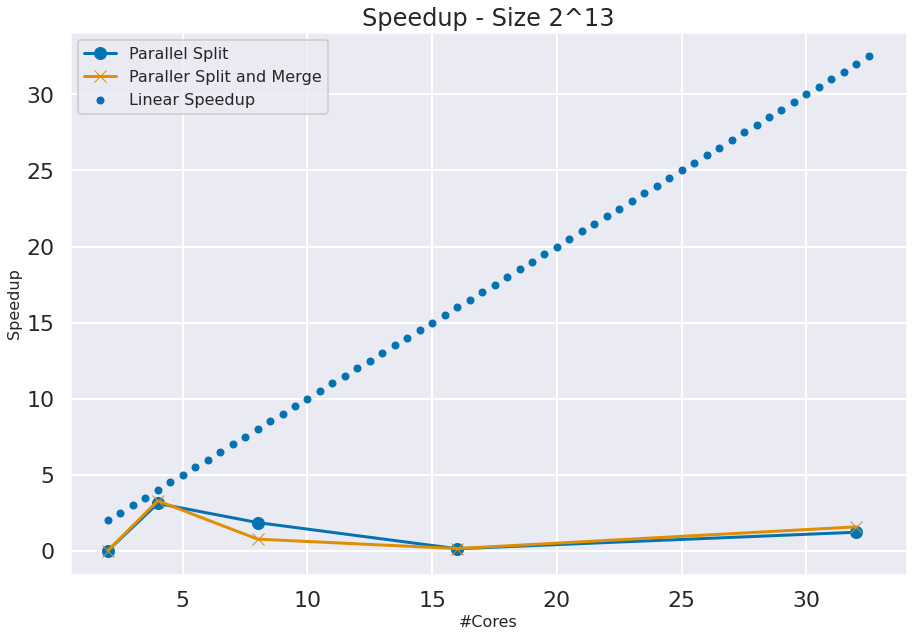

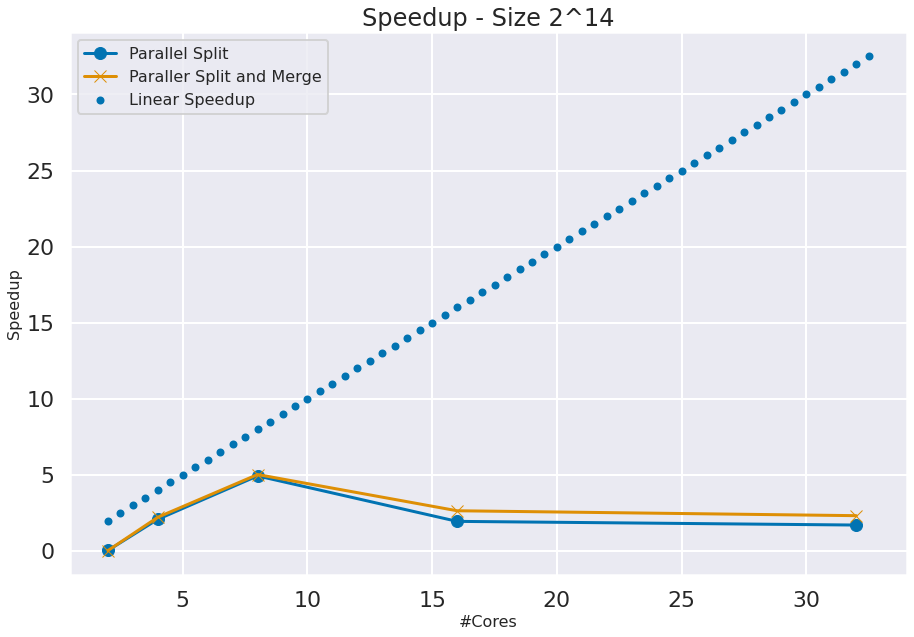

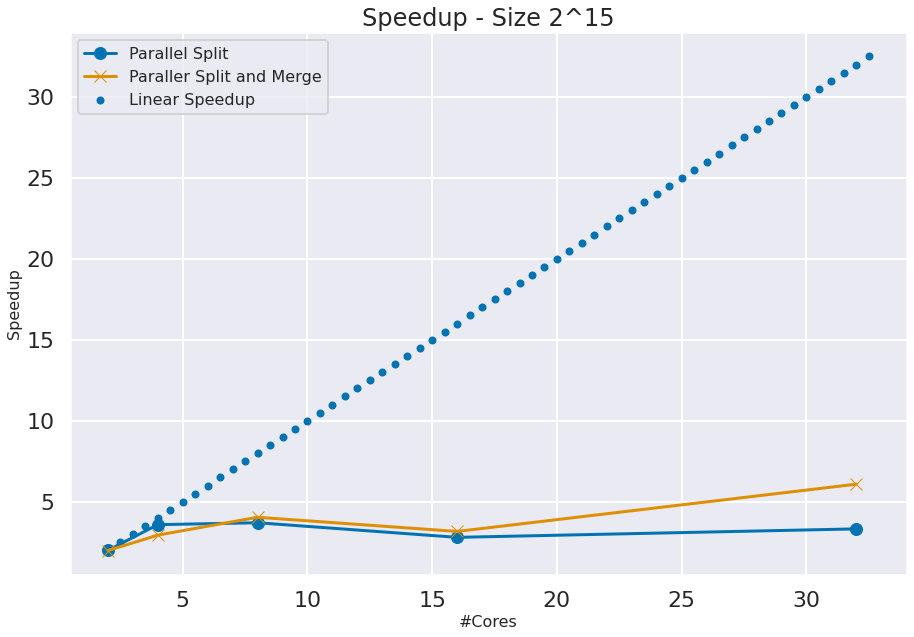

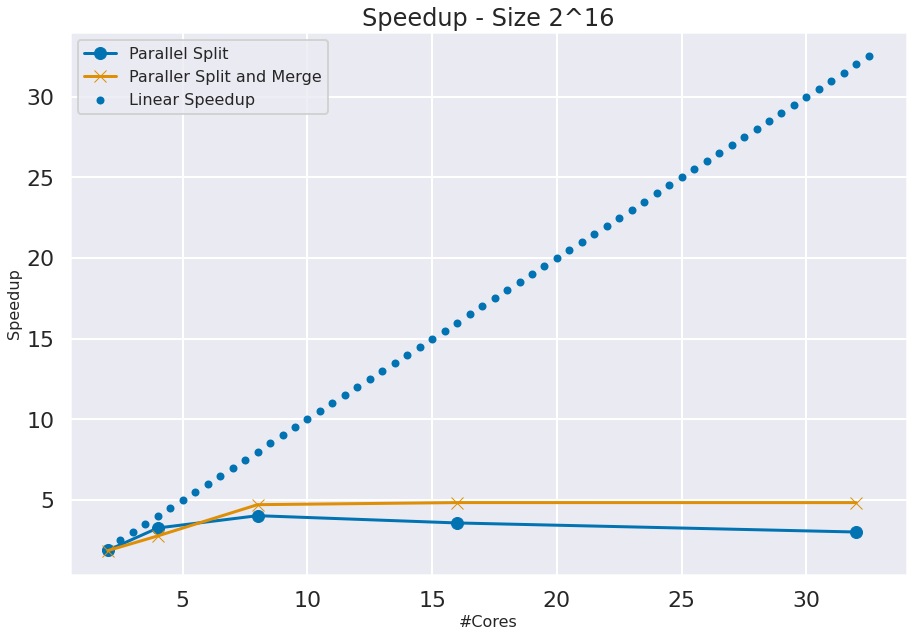

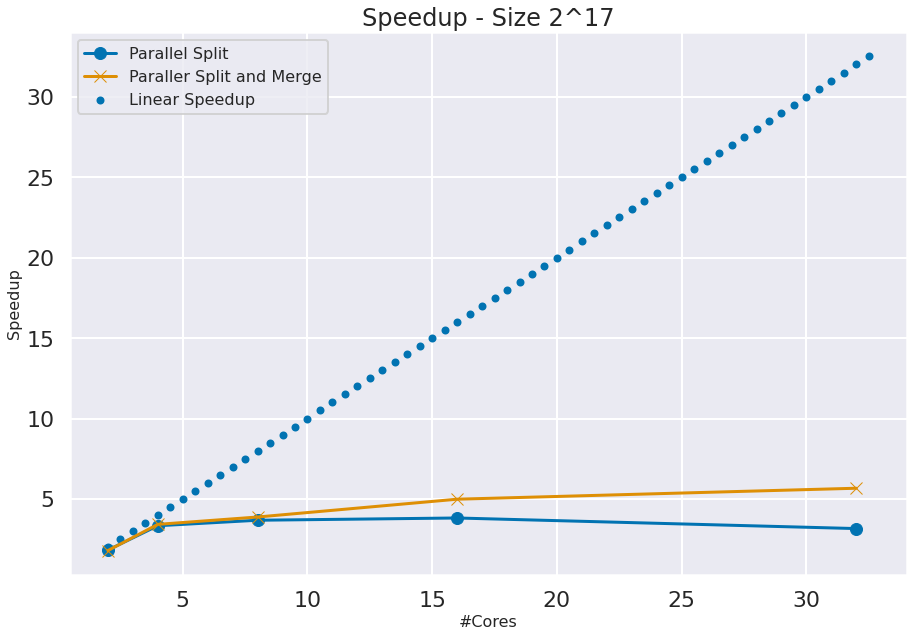

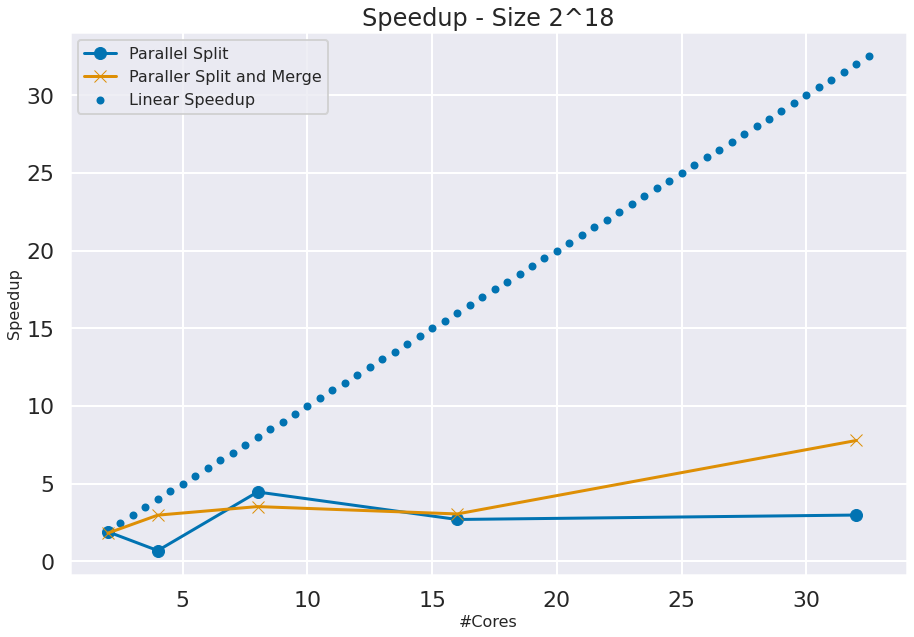

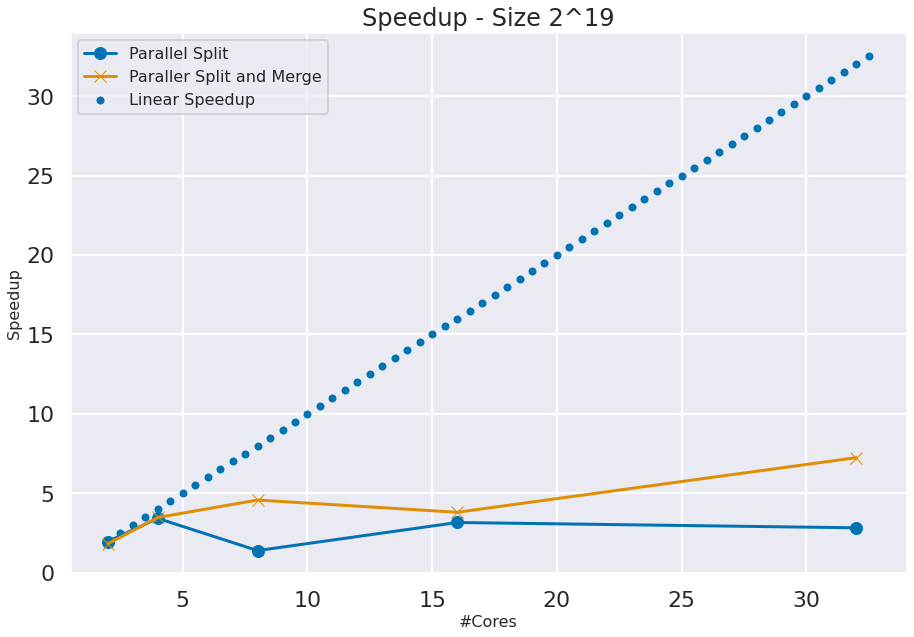

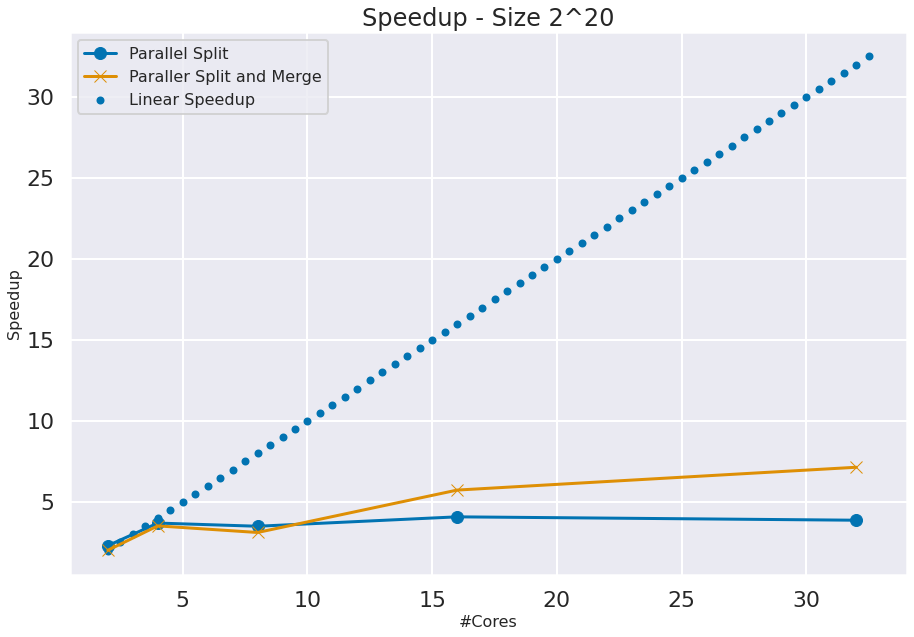

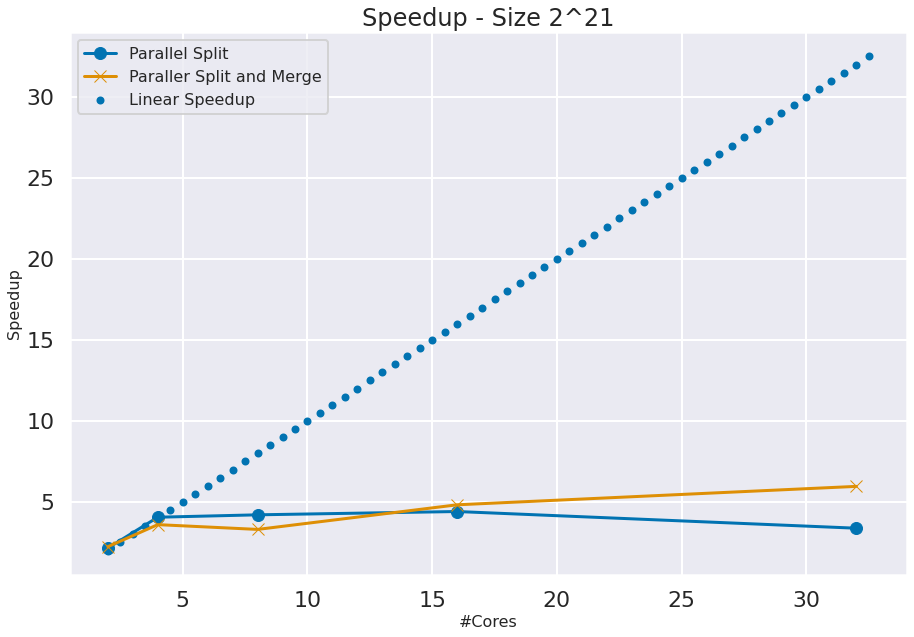

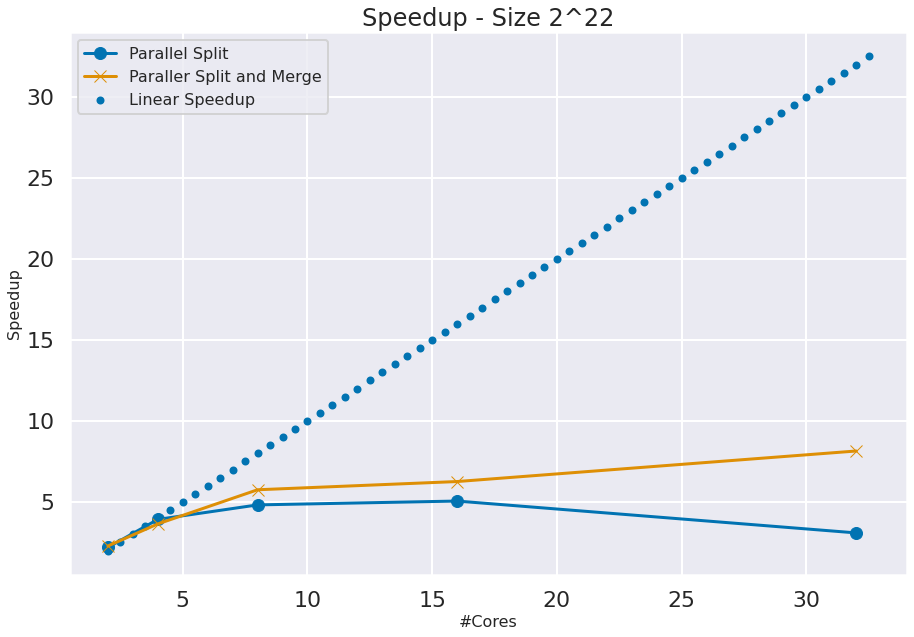

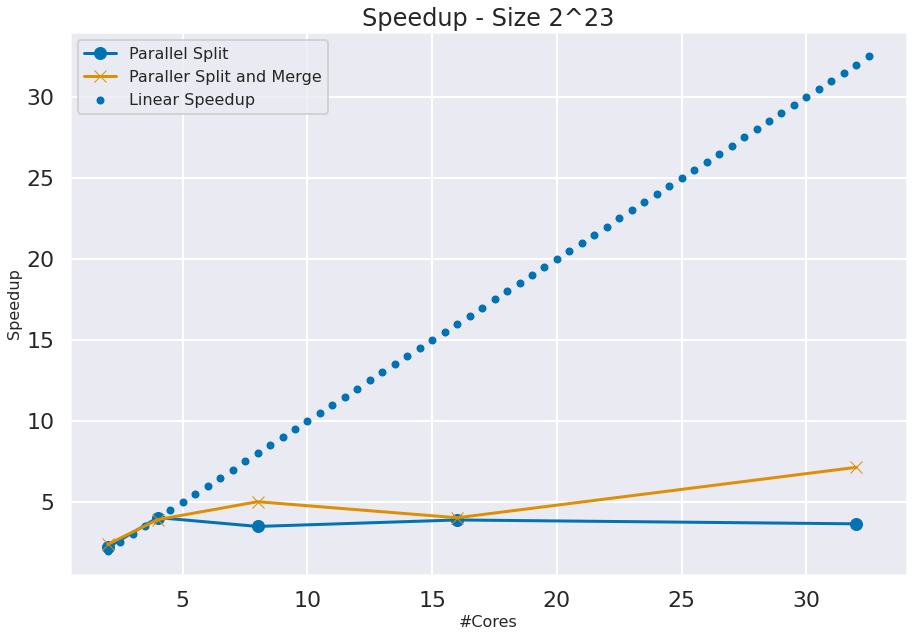

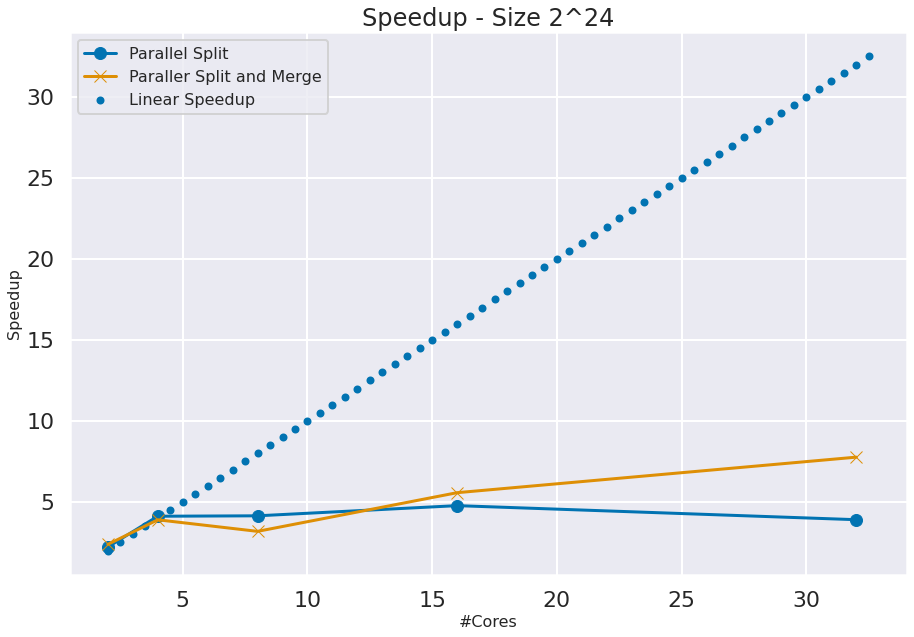

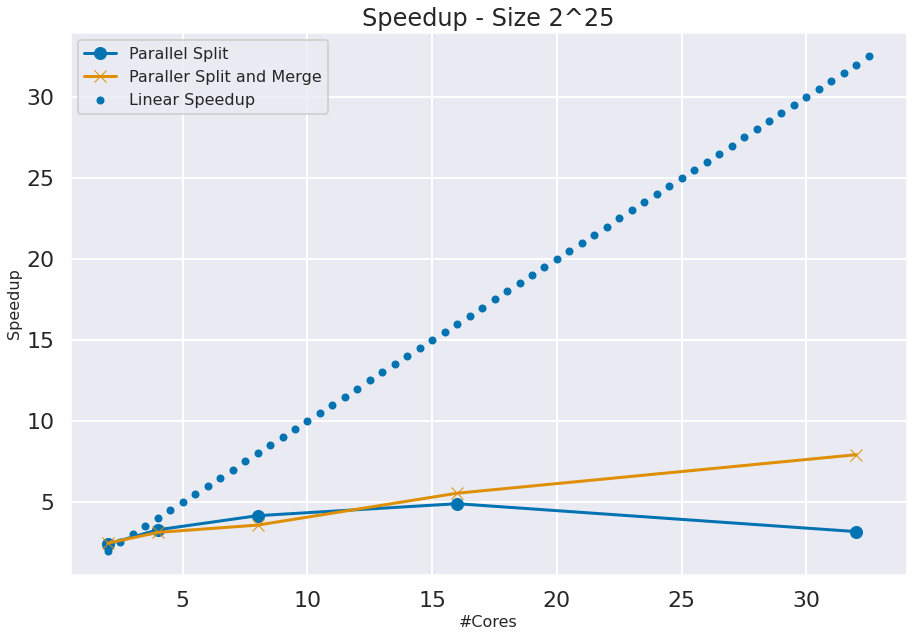

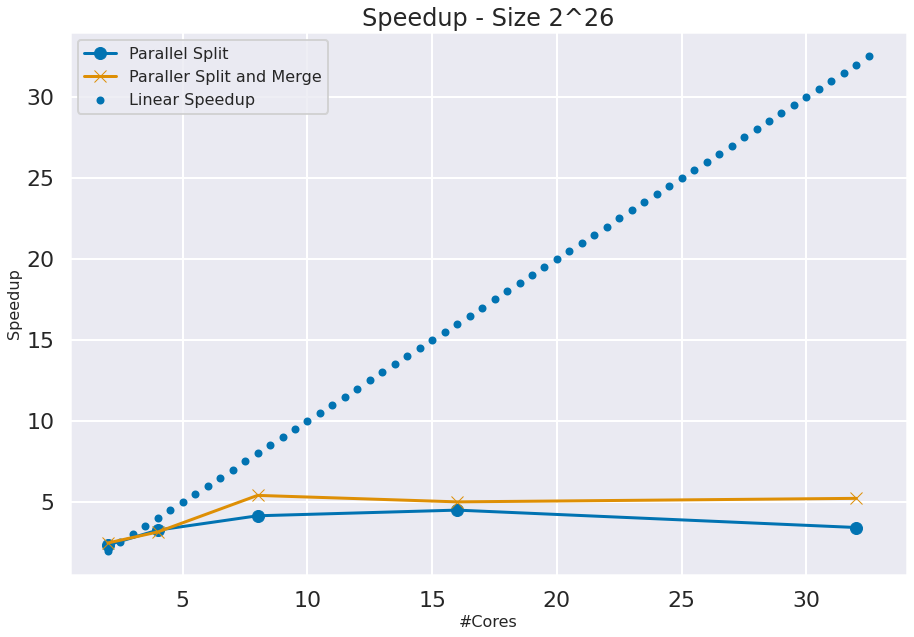

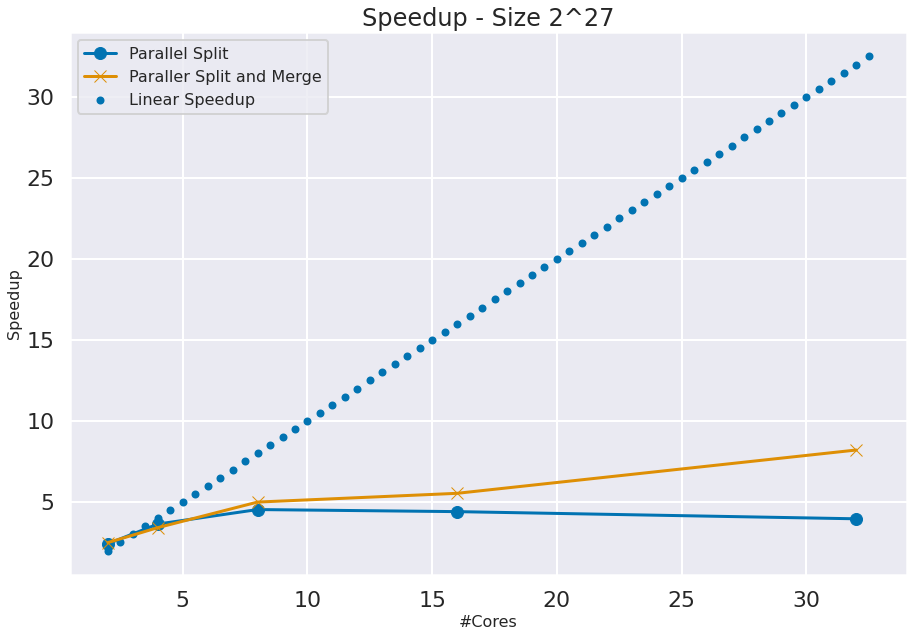

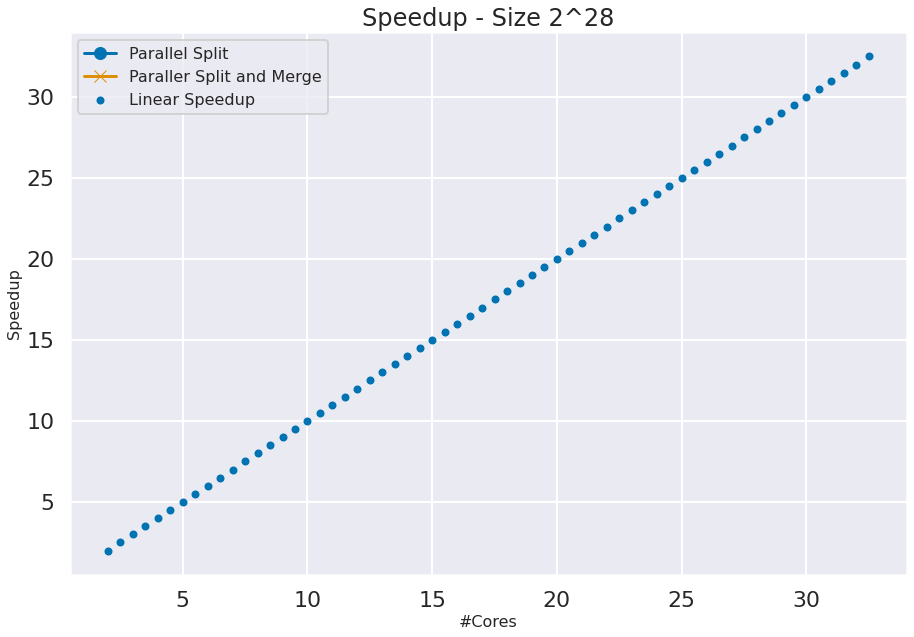

In [ ]:
for i in range(29):
    plot_speedup(i)

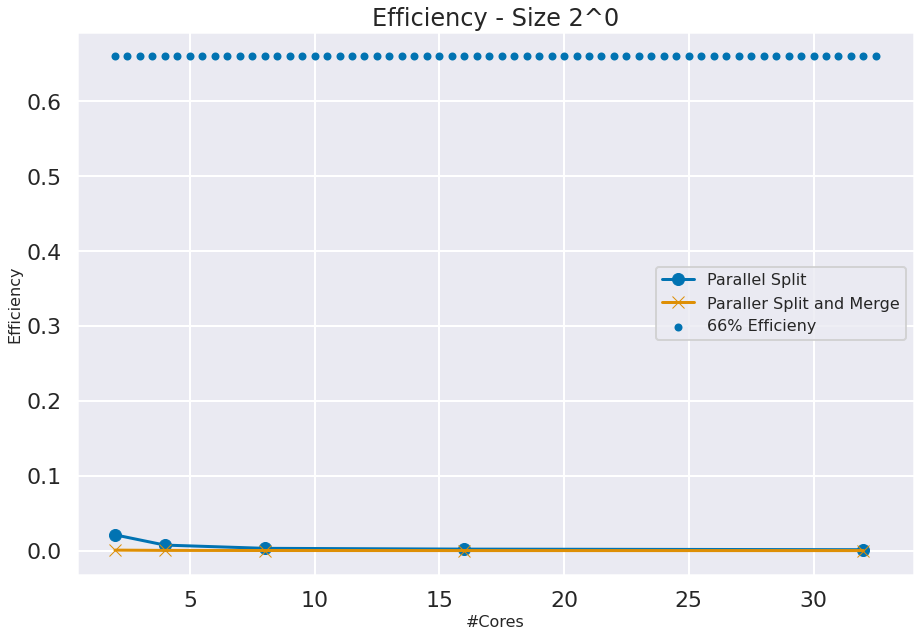

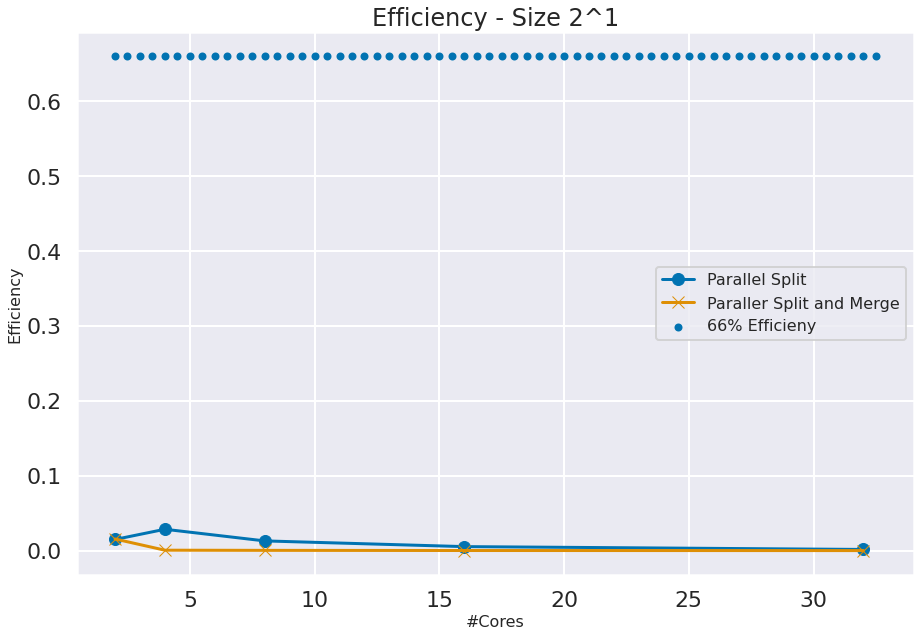

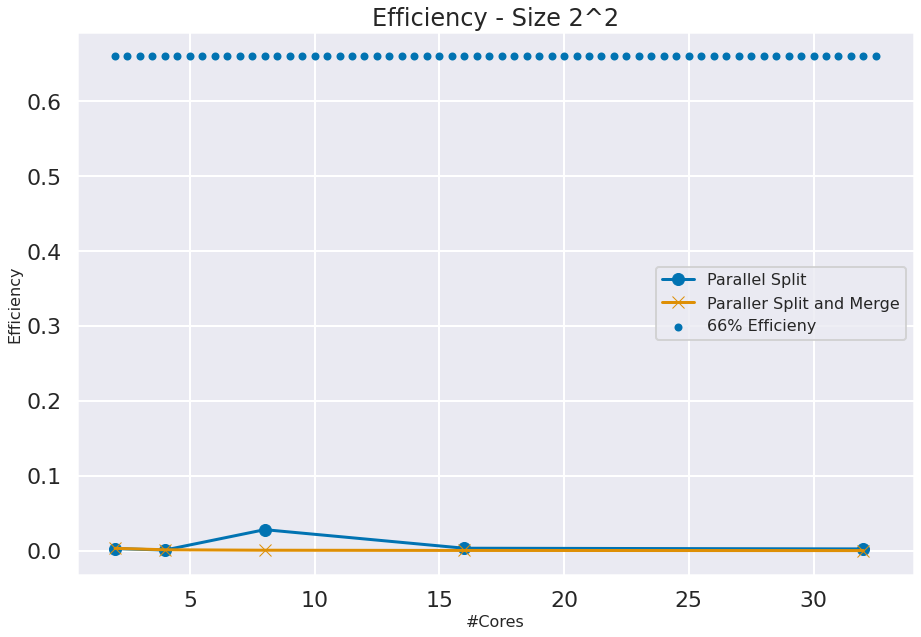

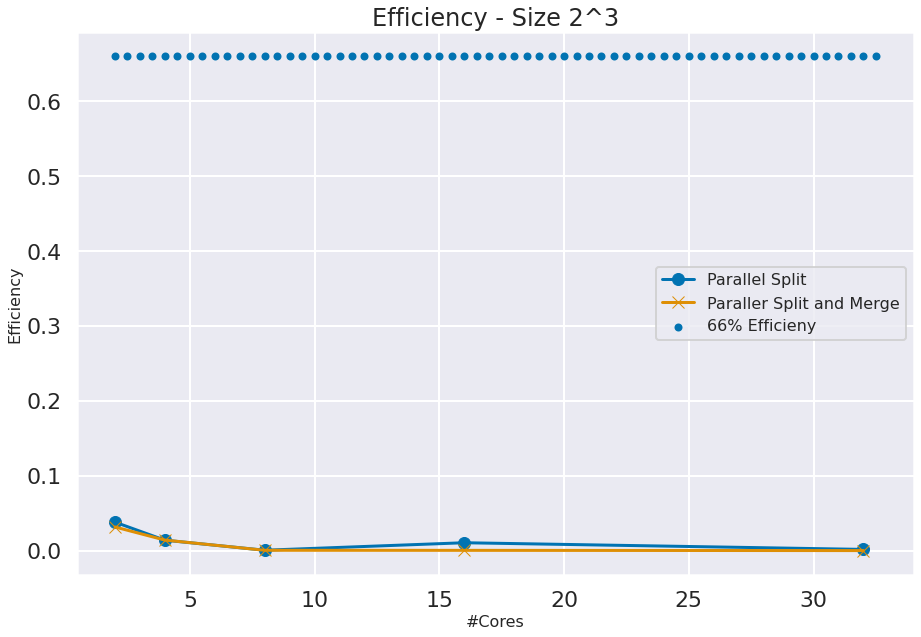

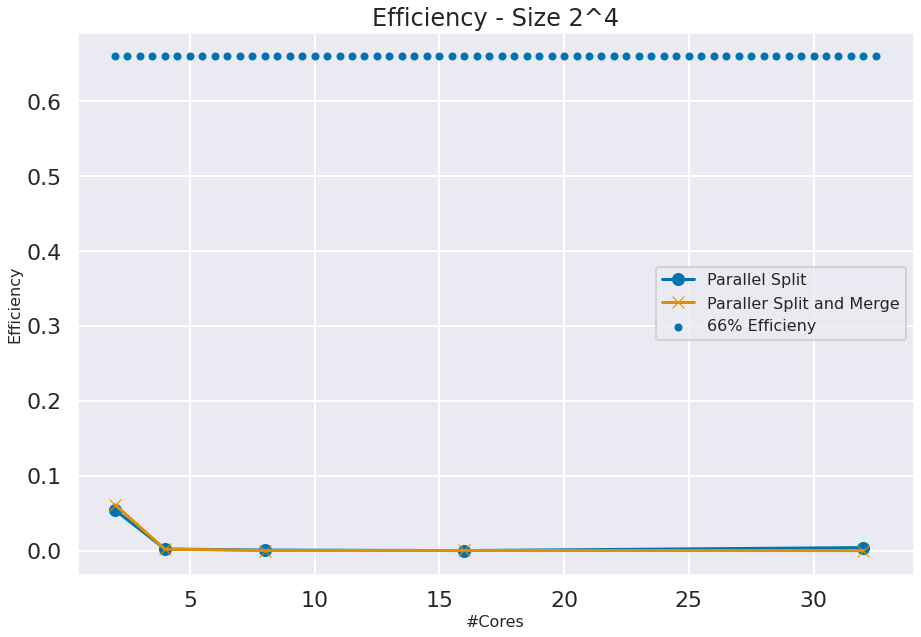

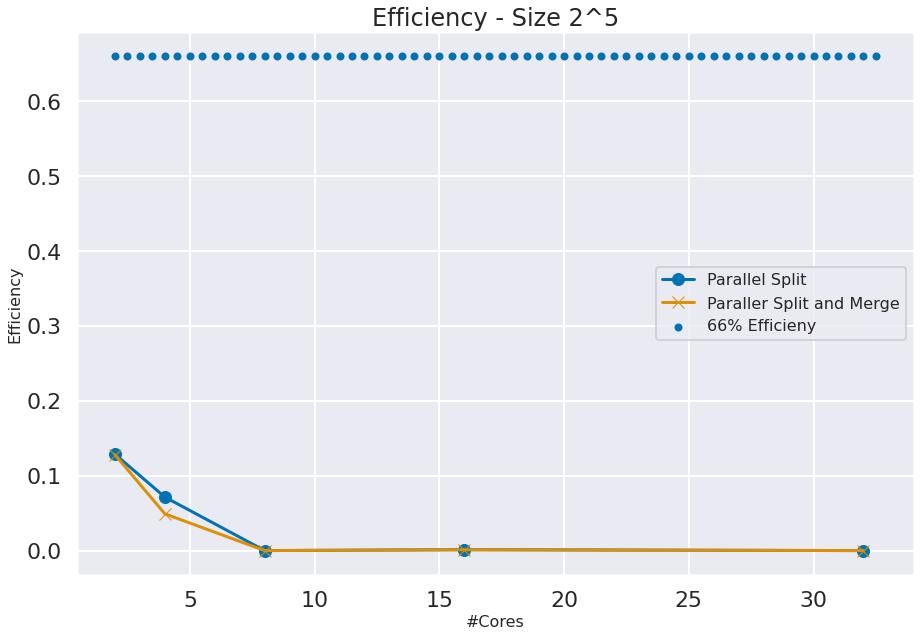

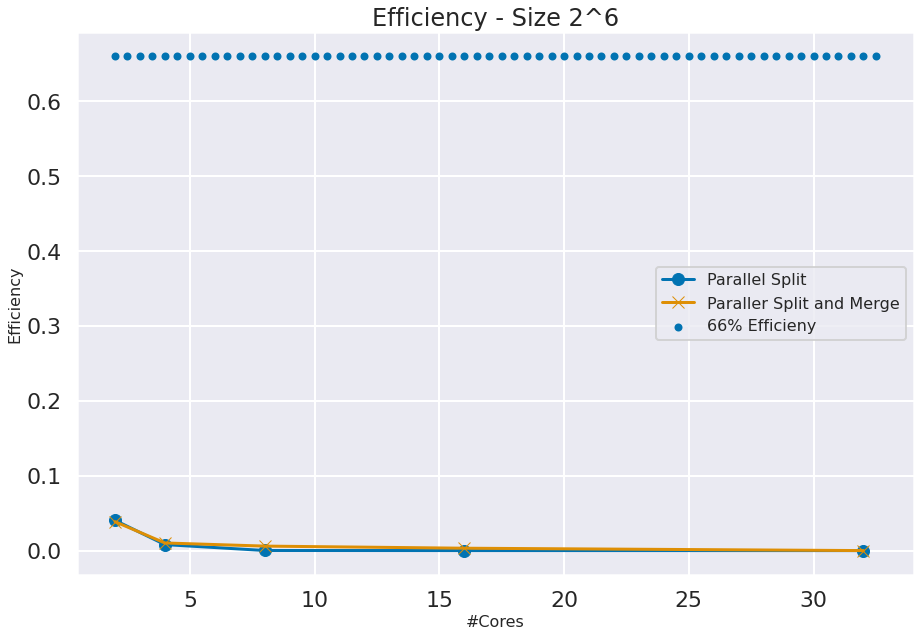

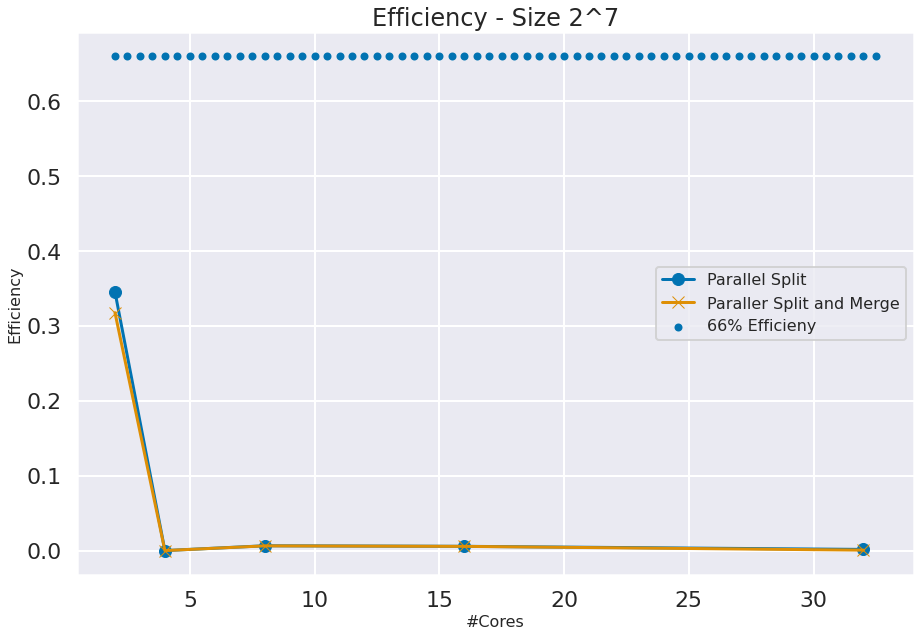

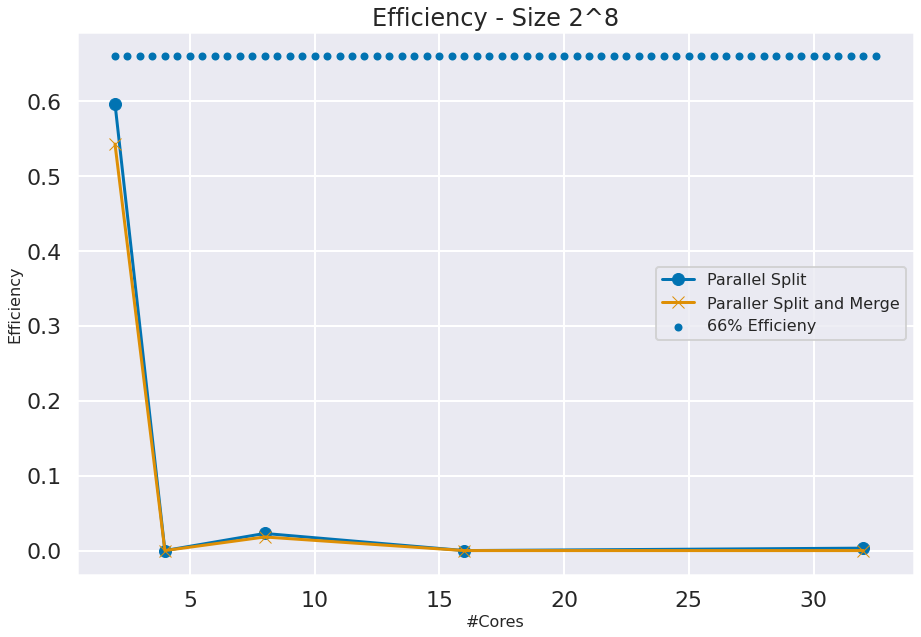

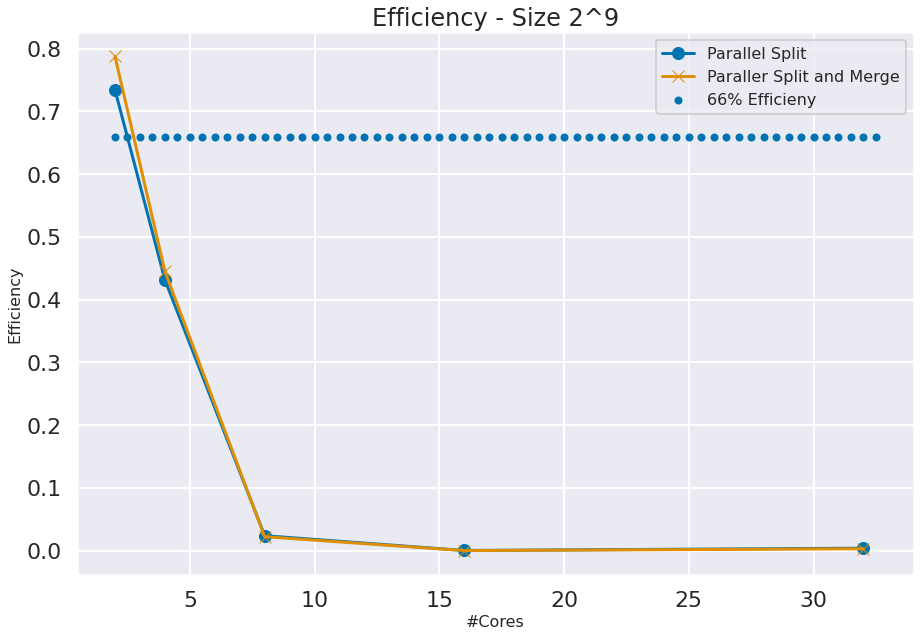

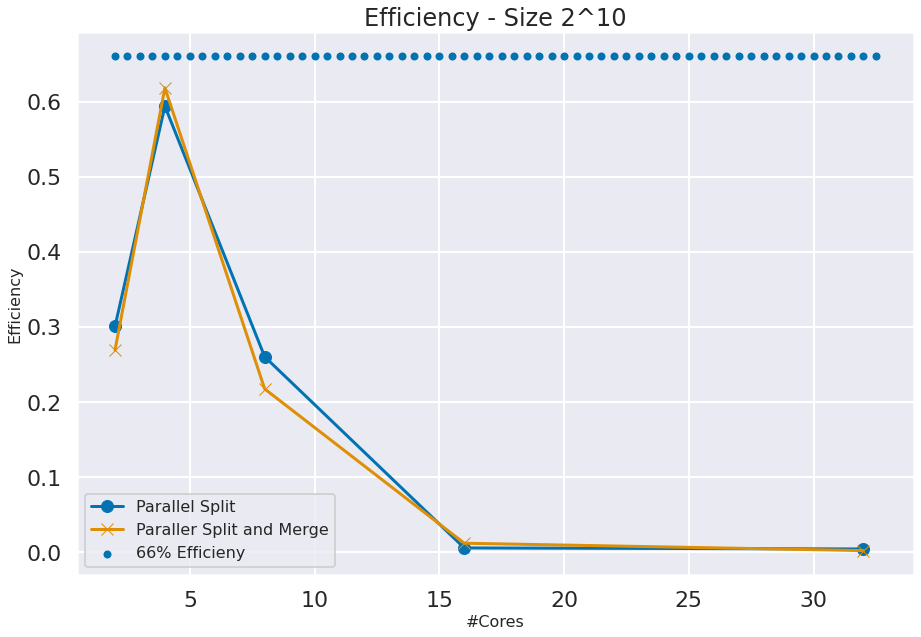

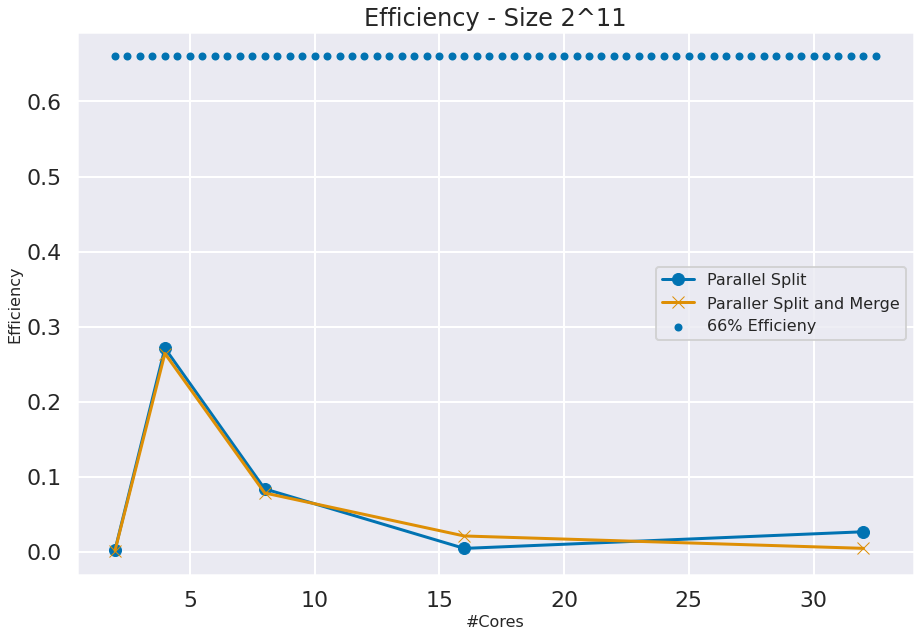

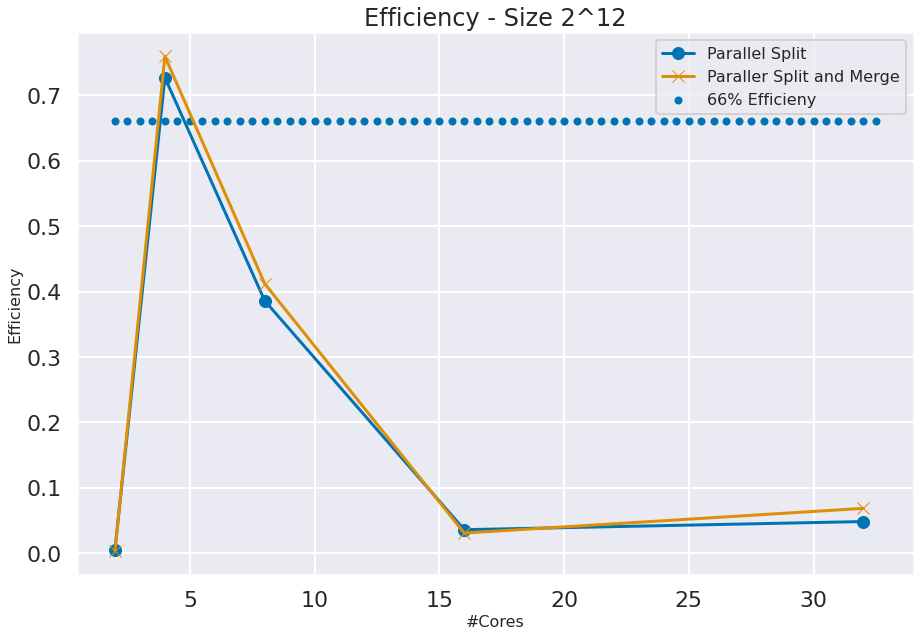

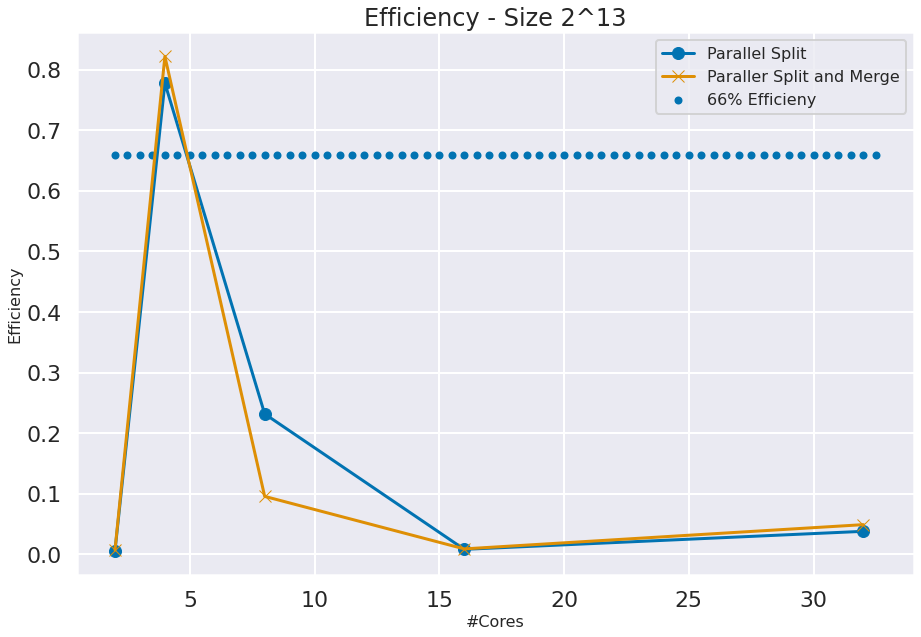

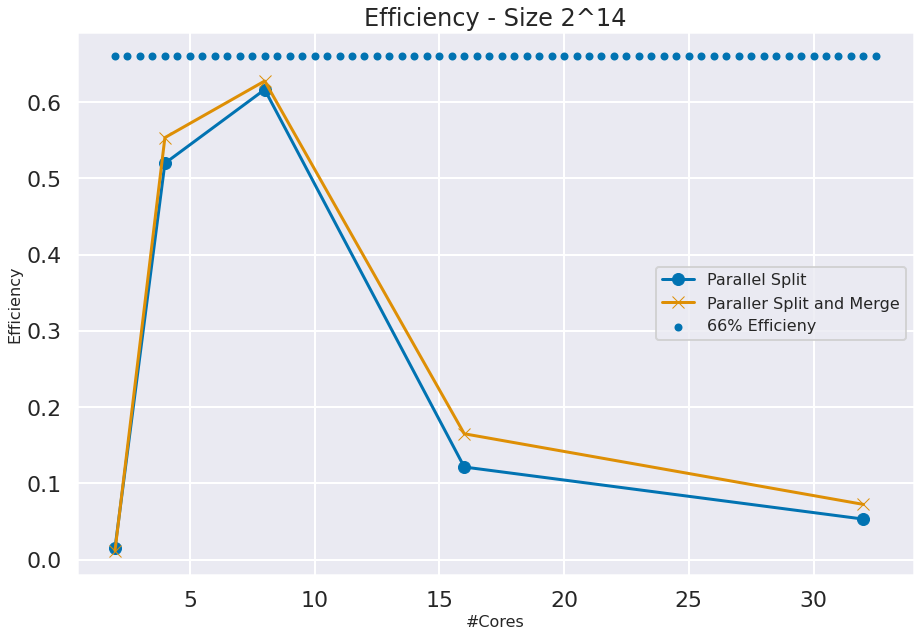

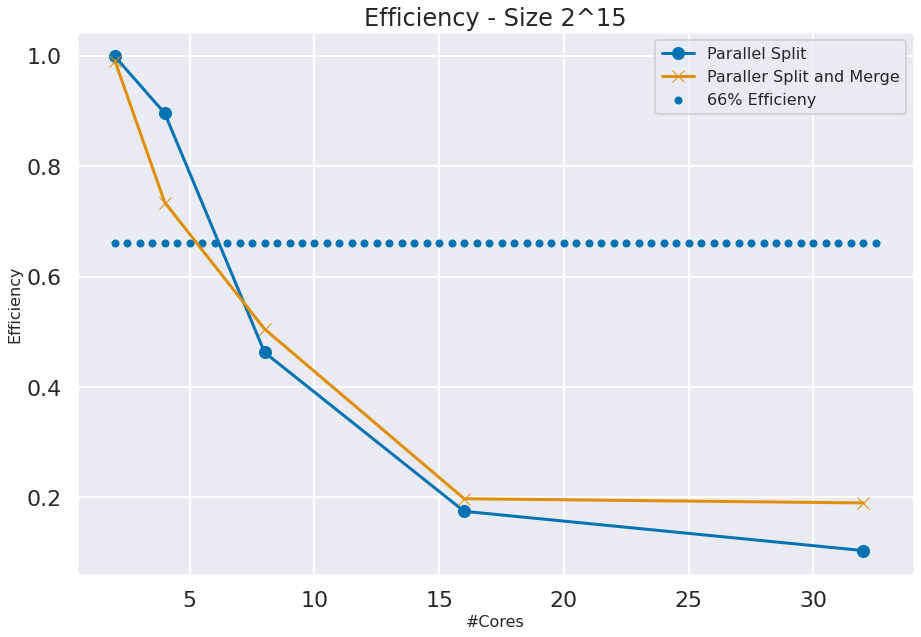

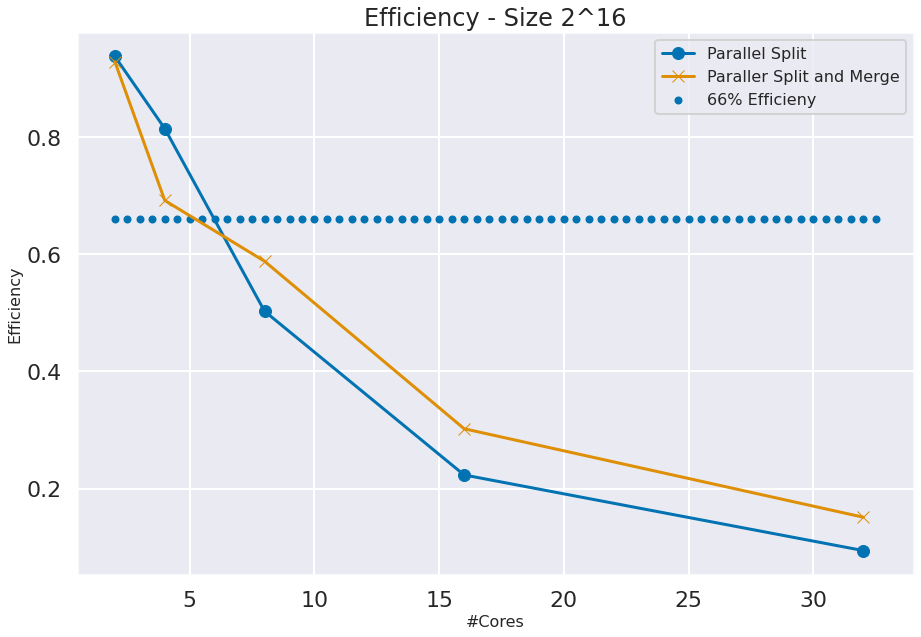

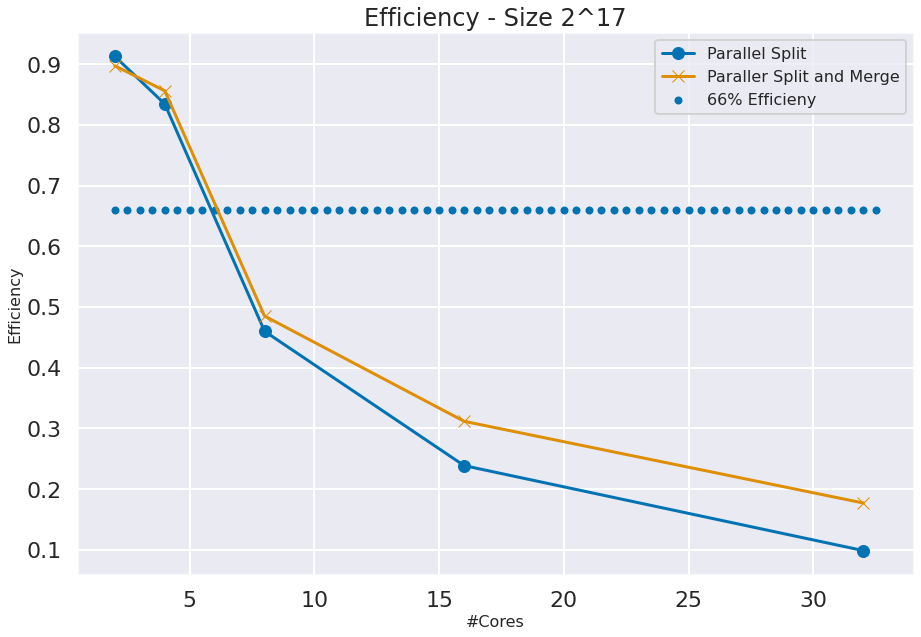

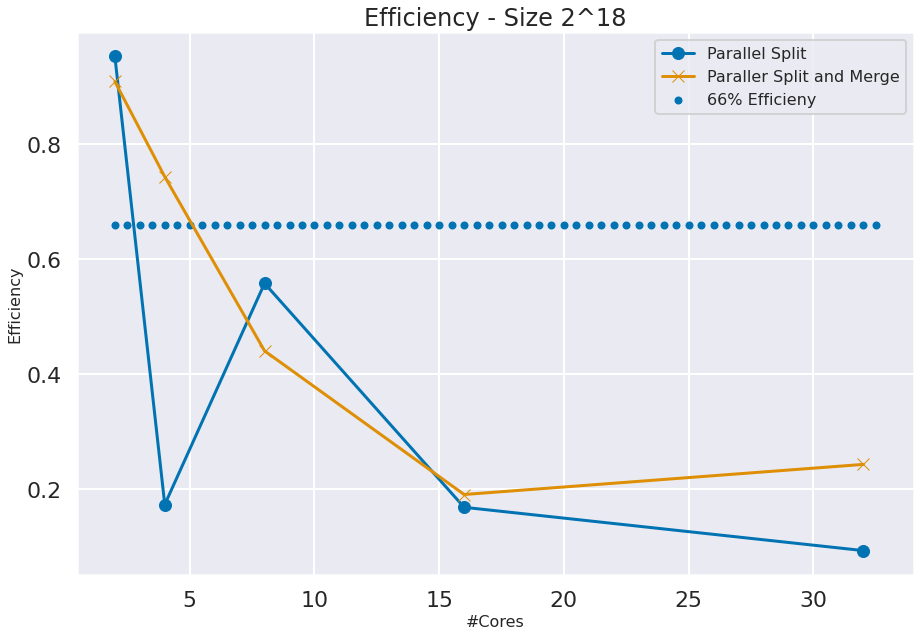

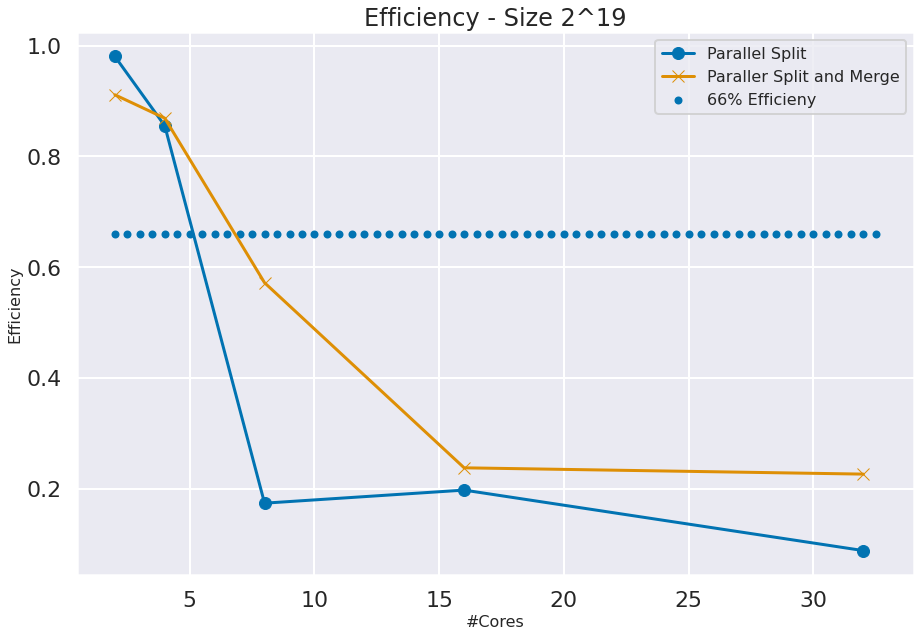

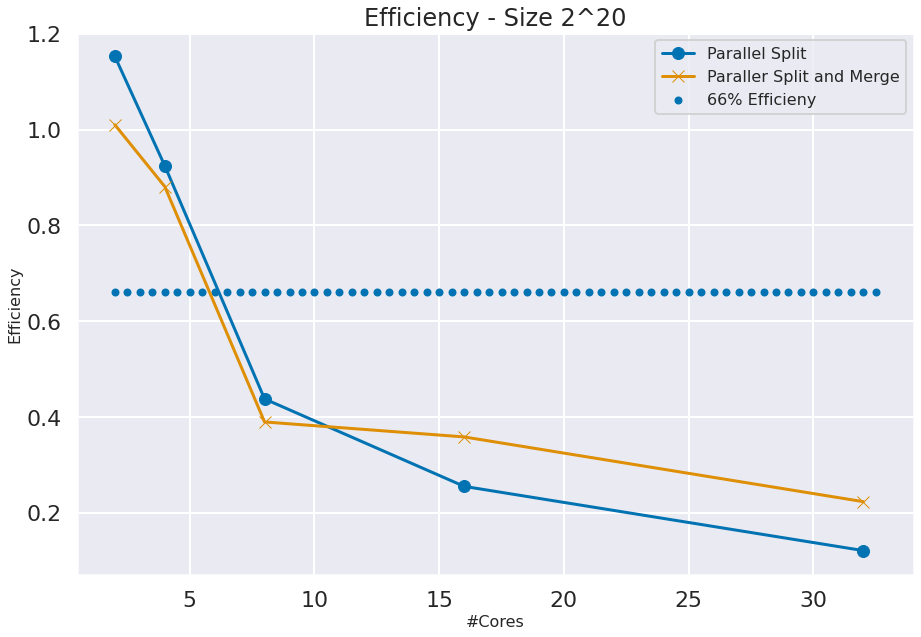

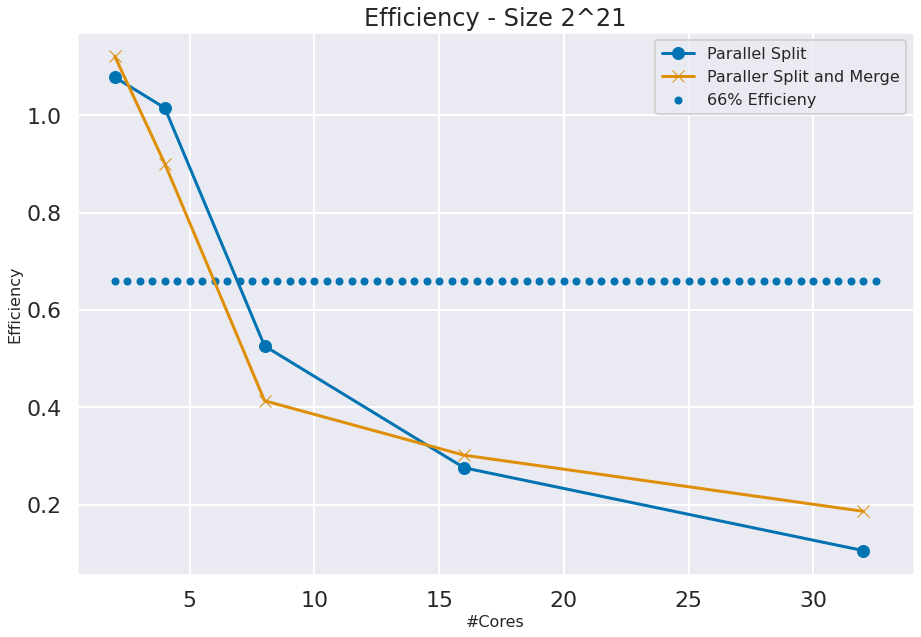

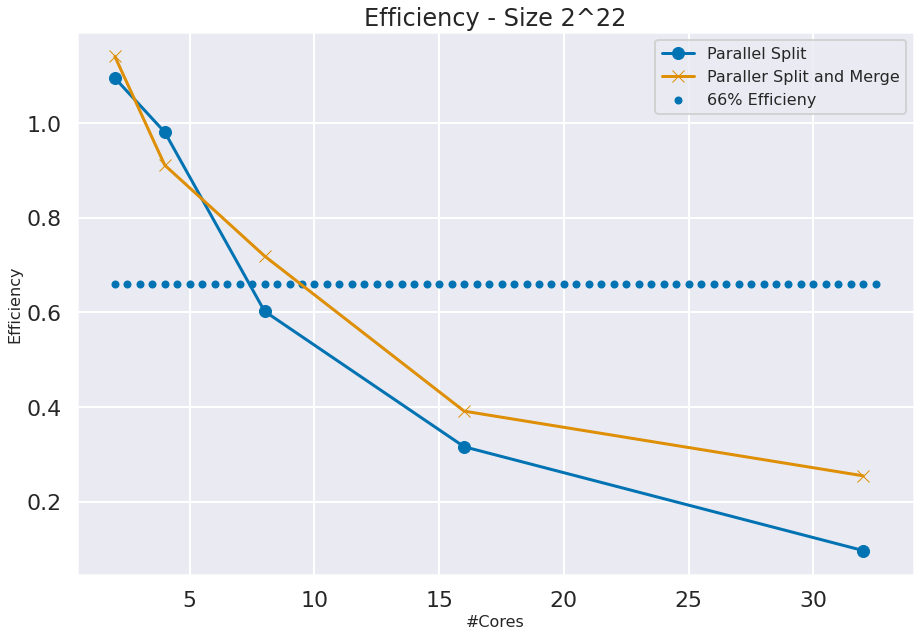

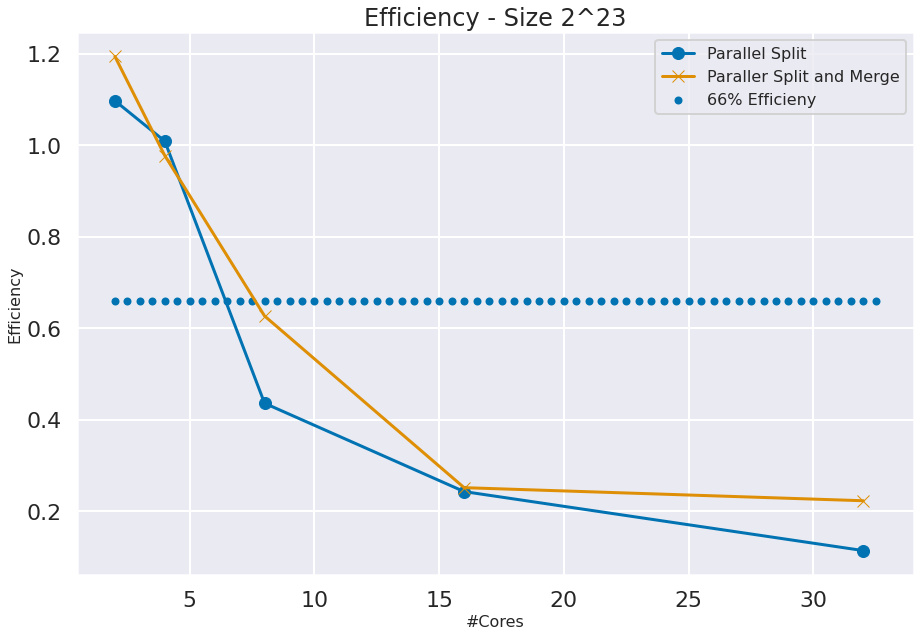

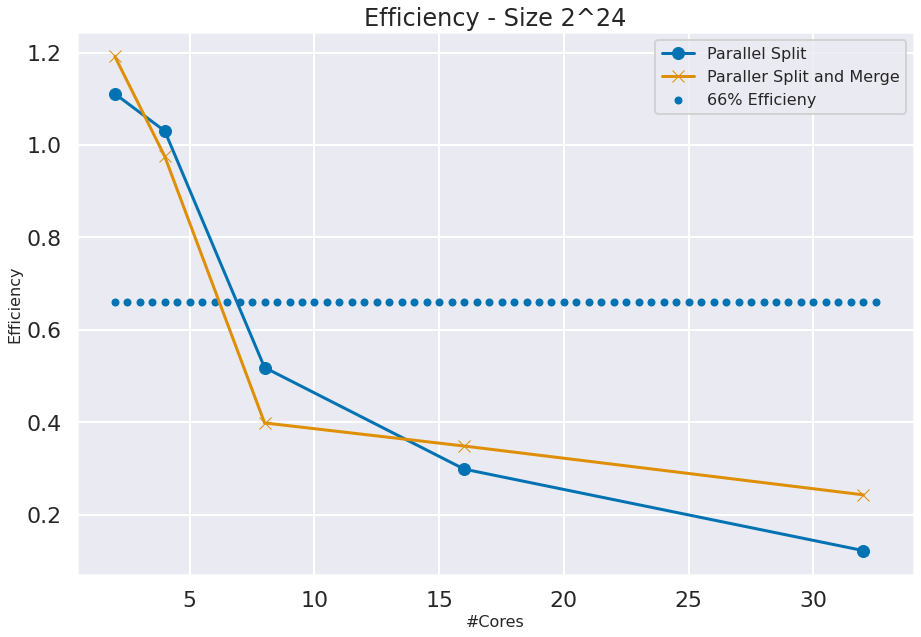

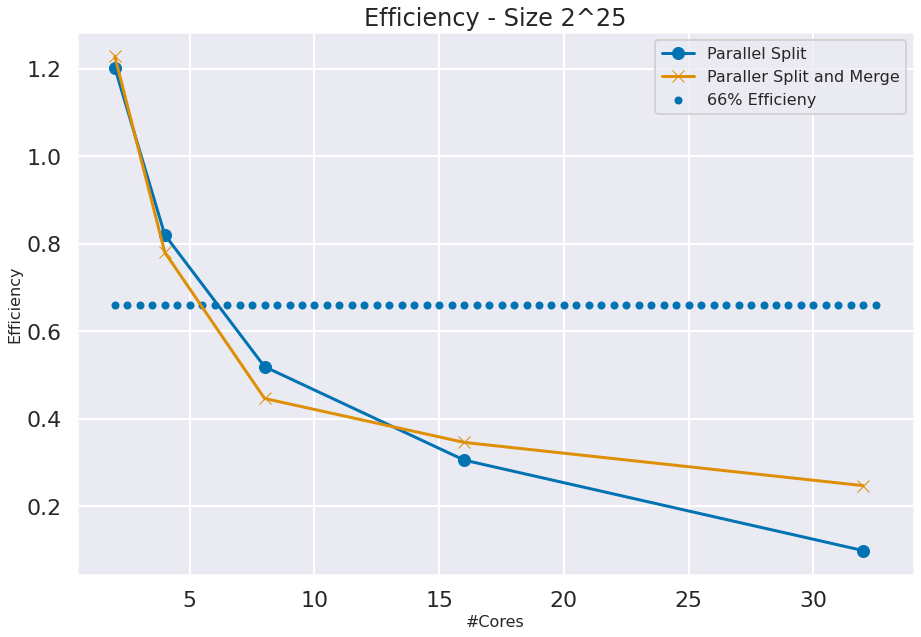

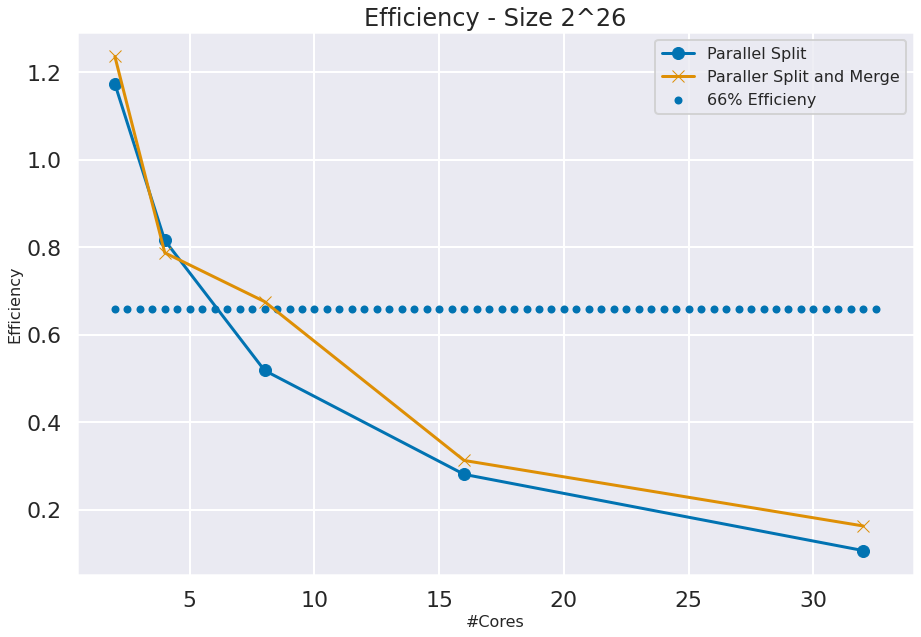

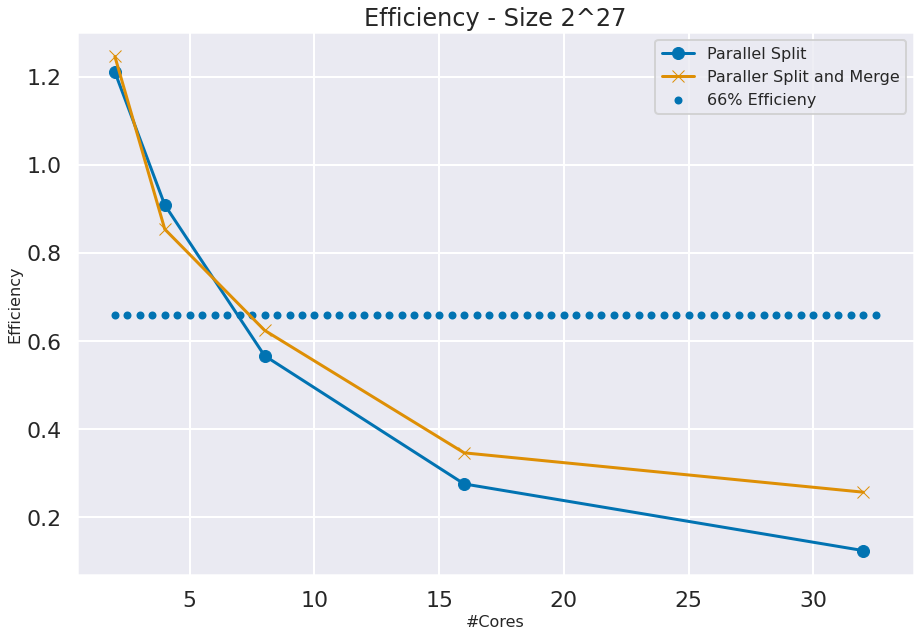

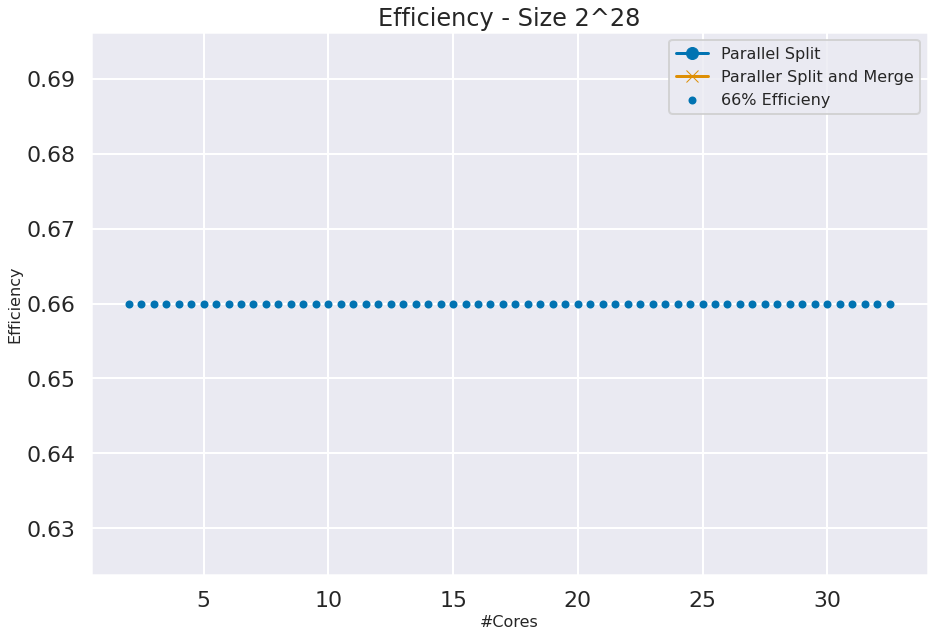

In [ ]:
for i in range(29):    
    plot_efficiency(i)

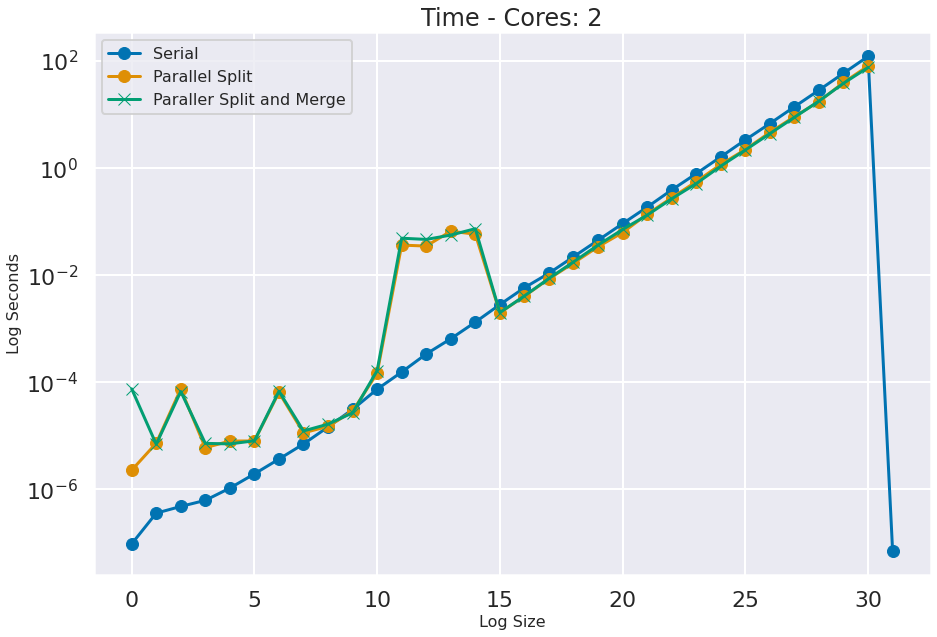

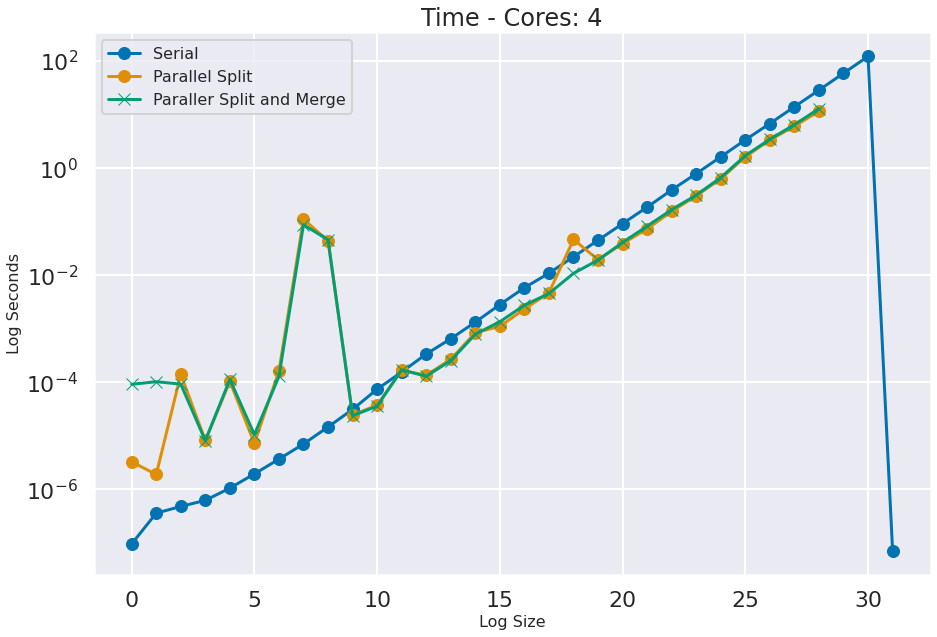

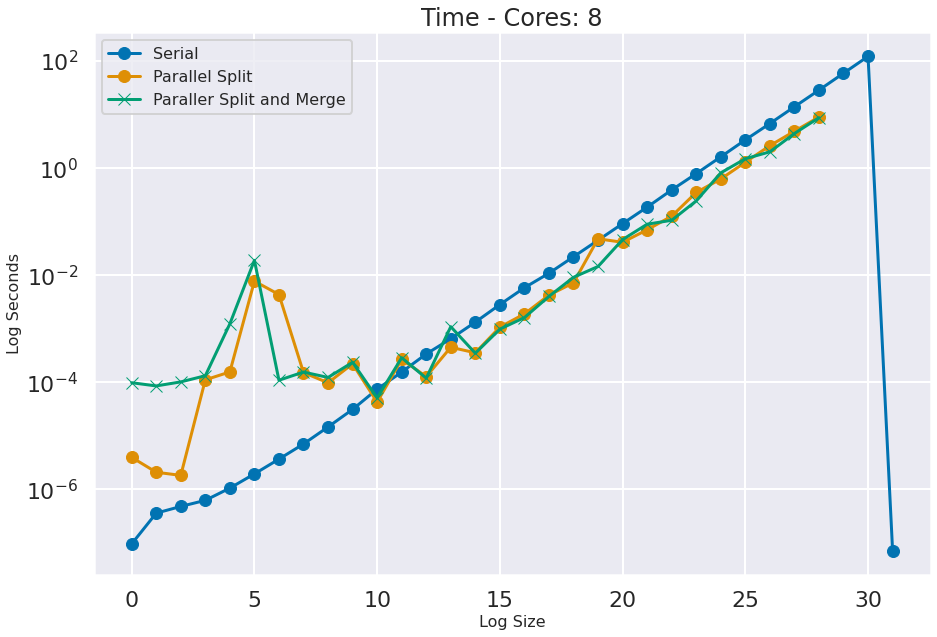

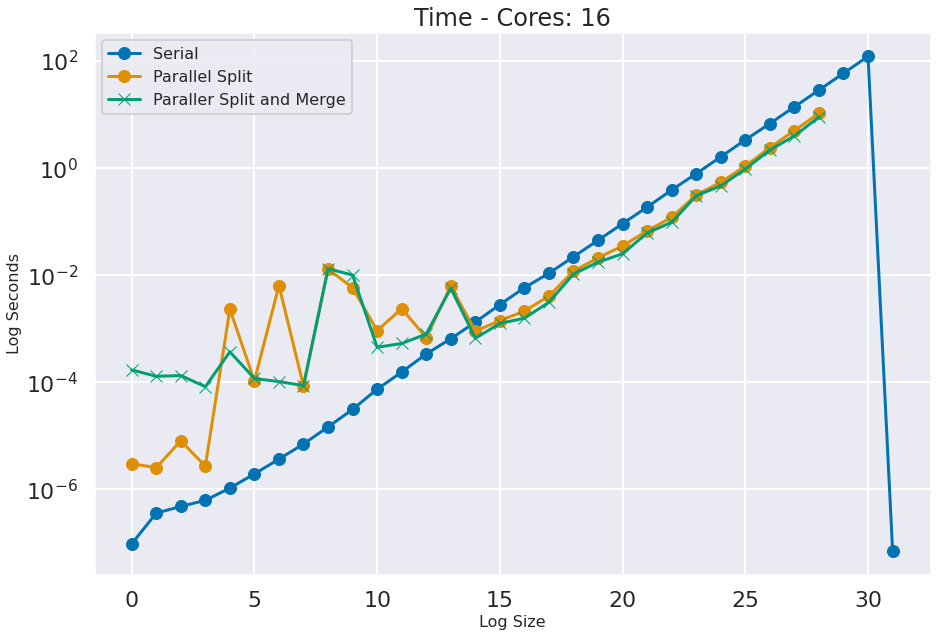

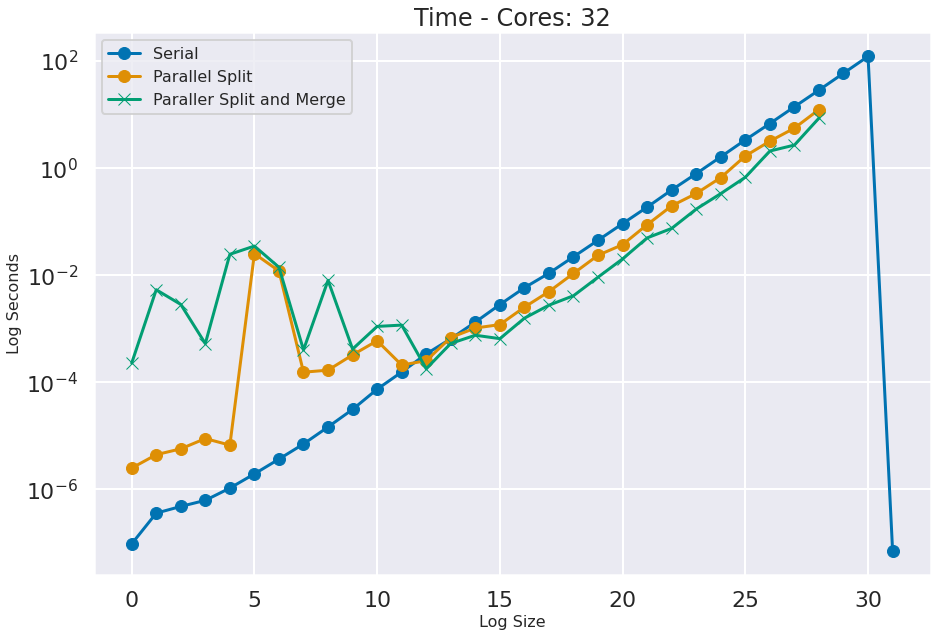

In [ ]:
for i in [2,4,8,16,32]:    
    plot_time(i)

## To Latex

In [ ]:
print(time_ser.to_latex())
print("\n ########################################################## \n")
print(time_p1.to_latex())
print("\n ########################################################## \n")
print(time_p2.to_latex())

\begin{tabular}{lr}
\toprule
{} &             1 \\
\midrule
0  &  9.536743e-08 \\
1  &  3.576279e-07 \\
2  &  4.768372e-07 \\
3  &  6.198883e-07 \\
4  &  1.049042e-06 \\
5  &  1.931190e-06 \\
6  &  3.647804e-06 \\
7  &  6.985664e-06 \\
8  &  1.451969e-05 \\
9  &  3.087521e-05 \\
10 &  7.355213e-05 \\
11 &  1.537085e-04 \\
12 &  3.340244e-04 \\
13 &  6.431103e-04 \\
14 &  1.313353e-03 \\
15 &  2.793169e-03 \\
16 &  5.760145e-03 \\
17 &  1.074040e-02 \\
18 &  2.179577e-02 \\
19 &  4.433482e-02 \\
20 &  9.046867e-02 \\
21 &  1.839343e-01 \\
22 &  3.850481e-01 \\
23 &  7.760364e-01 \\
24 &  1.597620e+00 \\
25 &  3.310150e+00 \\
26 &  6.682985e+00 \\
27 &  1.373232e+01 \\
28 &  2.808158e+01 \\
29 &  5.808257e+01 \\
30 &  1.196734e+02 \\
31 &  7.152557e-08 \\
\bottomrule
\end{tabular}


 ########################################################## 

\begin{tabular}{lrrrrr}
\toprule
{} &         2  &         4  &        8  &         16 &         32 \\
\midrule
0  &   0.000002 &   0.000003 &  0.

In [ ]:
print(speedup_p1.to_latex())
print("\n ########################################################## \n")
print(speedup_p2.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &            2  &            4  &            8  &            16 &            32 \\
\midrule
0  &  2.105263e-01 &  1.470588e-01 &  1.212121e-01 &  1.587302e-01 &  1.923077e-01 \\
1  &  6.600661e-02 &  2.531645e-01 &  2.298850e-01 &  1.886793e-01 &  1.081081e-01 \\
2  &  6.432937e-03 &  3.417634e-03 &  2.631579e-01 &  5.970150e-02 &  8.403362e-02 \\
3  &  8.000001e-02 &  5.865103e-02 &  4.336516e-03 &  1.769912e-01 &  5.405406e-02 \\
4  &  6.024097e-02 &  4.631776e-03 &  3.084516e-03 &  2.084224e-04 &  7.168460e-02 \\
5  &  5.988024e-02 &  6.644519e-02 &  6.234045e-05 &  4.515692e-03 &  1.912727e-05 \\
6  &  7.429421e-03 &  2.943341e-03 &  1.109367e-04 &  7.547056e-05 &  4.025774e-05 \\
7  &  4.237287e-02 &  4.345946e-06 &  3.174604e-03 &  5.622716e-03 &  3.121586e-03 \\
8  &  3.200001e-02 &  1.106322e-05 &  4.923683e-03 &  3.708449e-05 &  2.859185e-03 \\
9  &  1.670844e-02 &  1.964637e-02 &  2.180787e-03 &  8.287683e-05 &  1.483240e-03 \\
10 &  3.2605

In [ ]:
print(efficiency_p1.to_latex())
print("\n ########################################################## \n")
print(efficiency_p2.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &            2  &            4  &            8  &            16 &            32 \\
\midrule
0  &  1.052631e-01 &  3.676471e-02 &  1.515151e-02 &  9.920636e-03 &  6.009616e-03 \\
1  &  3.300330e-02 &  6.329114e-02 &  2.873563e-02 &  1.179245e-02 &  3.378378e-03 \\
2  &  3.216468e-03 &  8.544085e-04 &  3.289474e-02 &  3.731344e-03 &  2.626051e-03 \\
3  &  4.000001e-02 &  1.466276e-02 &  5.420645e-04 &  1.106195e-02 &  1.689189e-03 \\
4  &  3.012048e-02 &  1.157944e-03 &  3.855645e-04 &  1.302640e-05 &  2.240144e-03 \\
5  &  2.994012e-02 &  1.661130e-02 &  7.792557e-06 &  2.822307e-04 &  5.977271e-07 \\
6  &  3.714711e-03 &  7.358353e-04 &  1.386709e-05 &  4.716910e-06 &  1.258054e-06 \\
7  &  2.118644e-02 &  1.086487e-06 &  3.968254e-04 &  3.514198e-04 &  9.754955e-05 \\
8  &  1.600000e-02 &  2.765804e-06 &  6.154604e-04 &  2.317781e-06 &  8.934954e-05 \\
9  &  8.354221e-03 &  4.911592e-03 &  2.725984e-04 &  5.179802e-06 &  4.635124e-05 \\
10 &  1.6302